In [1]:
from typing import Dict, List, Tuple, Union
from skimage import exposure, img_as_ubyte
import rasterio
import pathlib
import re
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
def load_landsat_image(
    img_folder: Union[str, None],
    bands: Union[List[str], None]
) -> Dict:
    """
    Take a folder path and return a dict with the raw vectors extracted from the Earth Engine.
    """
    # Dictionary to save the image.
    images_dict = {}

    if img_folder:
        # Use the provided path.
        path = pathlib.Path(img_folder)
    else:
        # Get the path to retrieve.
        path = pathlib.Path(__file__).parent

    # Get the list of all files.
    files = [f.name for f in path.glob('**/*.tif')]
    # Parse all of filenames to get the unique ones.
    files = set([re.search('_[0-9](.*)[0-9]_', x).group() for x in files])
    # Dict of images to return.
    images_dict = {}

    # Iterate over the files.
    for pat in files:
        image = {}
        # Iterate over the bands.
        for band in bands:
            file = next(path.glob(f'*{pat}{band}.tif'))
            #print(f'Opening file {file}')
            ds = rasterio.open(file)
            image.update({band: ds.read(1)})
        # Update the main dict.
        images_dict.update(
            {pat.replace('_','') : image}
        )

    return images_dict

def display_rgb(
    img: Union[Dict, None], 
    alpha=1., 
    figsize=(10, 10)
    ) -> None:
    rgb = np.stack(
        [img['B4'], img['B3'], img['B2']],
        axis=-1
    )
    rgb = rgb/rgb.max() * alpha
    plt.figure(figsize=figsize)
    plt.imshow(rgb)
    
def convert_to_eight_bits(
    img: Union[Dict, None]
) -> np.array:
    """
    To reescale image to 8 bits.
    """
    img_stack = np.stack(
        [img['B4'], img['B3'], img['B2']]
        , axis=-1)

    scaled_img = img_as_ubyte(
        exposure.rescale_intensity(img_stack)
    )
    
    return scaled_img

In [3]:
IMGS_PATH = '/home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba2/'
band_labels = ["B4", "B3", "B2"]
images = load_landsat_image(IMGS_PATH, band_labels)
img_keys = list(images.keys())

In [4]:
#Edge detection

def edge_detection_preprocessing(image_data, canny_parameter1=100, canny_parameter2=100, band="all"):

    if band == "all":

        image = convert_to_eight_bits(image_data)

        hsv_filter = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        grayscale_filter = cv2.cvtColor(cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2HSV_FULL), cv2.COLOR_RGB2GRAY)
        gaussian_filter = cv2.GaussianBlur(hsv_filter, (1,1), 0)
        grayscale_gaussian_filter = cv2.GaussianBlur(grayscale_filter, (1,1), 0)

        grayscale_canny = cv2.Canny(grayscale_filter, canny_parameter1, canny_parameter2)
        gaussian_canny = cv2.Canny(gaussian_filter, canny_parameter1, canny_parameter2)
        grayscale_gaussian_canny = cv2.Canny(grayscale_gaussian_filter, canny_parameter1, canny_parameter2)

        return image, hsv_filter, grayscale_filter, gaussian_filter, grayscale_gaussian_filter, grayscale_canny, gaussian_canny, grayscale_gaussian_canny
    
    elif band == "R":

        image = image_data["B4"]
        image = image.astype(np.uint8)
        gaussian_filter = cv2.GaussianBlur(image, (5,5), 0)
        gaussian_canny = cv2.Canny(gaussian_filter, canny_parameter1, canny_parameter2)

        return image, gaussian_filter, gaussian_canny

    elif band == "G":

        image = image_data["B3"]
        image = image.astype(np.uint8)
        gaussian_filter = cv2.GaussianBlur(image, (5,5), 0)
        gaussian_canny = cv2.Canny(gaussian_filter, canny_parameter1, canny_parameter2)

        return image, gaussian_filter, gaussian_canny


    elif band == "B":

        image = image_data["B2"]
        image = image.astype(np.uint8)
        gaussian_filter = cv2.GaussianBlur(image, (5,5), 0)
        gaussian_canny = cv2.Canny(gaussian_filter, canny_parameter1, canny_parameter2)

        return image, gaussian_filter, gaussian_canny


    else:

        print("Not a valid color band")

def visualize_edge_detection(image, hsv_filter, grayscale_filter, gaussian_filter, grayscale_gaussian_filter, grayscale_canny, gaussian_canny, grayscale_gaussian_canny):
    fig, axes = plt.subplots(4, 2, figsize=(7, 10))

    fig.subplots_adjust()
    fig.tight_layout()
    axes = axes.ravel()

    axes[0].imshow(image)
    axes[0].set_title('Original Image'), axes[0].set_xticks([]), axes[0].set_yticks([])
    axes[1].imshow(hsv_filter)
    axes[1].set_title('HSV Filter'), axes[1].set_xticks([]), axes[1].set_yticks([])
    axes[2].imshow(gaussian_filter)
    axes[2].set_title("Gaussian Filter"), axes[2].set_xticks([]), axes[2].set_yticks([])
    axes[3].imshow(gaussian_canny)
    axes[3].set_title("Canny (Gaussian)"), axes[3].set_xticks([]), axes[3].set_yticks([])
    axes[4].imshow(grayscale_filter, cmap = "gray")
    axes[4].set_title("Grayscale"), axes[4].set_xticks([]), axes[4].set_yticks([])
    axes[5].imshow(grayscale_canny, cmap = "gray")
    axes[5].set_title("Canny (Grayscale)"), axes[5].set_xticks([]), axes[5].set_yticks([])
    axes[6].imshow(grayscale_gaussian_filter, cmap = "gray")
    axes[6].set_title("Gaussian + Grayscale"), axes[6].set_xticks([]), axes[6].set_yticks([])
    axes[7].imshow(grayscale_gaussian_canny, cmap = "gray")
    axes[7].set_title("Canny (Gaussian + Grayscale)"), axes[7].set_xticks([]), axes[7].set_yticks([])
    plt.show()

def visualize_filter_edges(filters, edges, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()
    fig.suptitle(title)
    fig.subplots_adjust()
    axes = axes.ravel()


    axes[0].imshow(filters)
    axes[0].set_title('Original Filter'), axes[0].set_xticks([]), axes[0].set_yticks([])
    axes[1].imshow(edges)
    axes[1].set_title('Edges'), axes[1].set_xticks([]), axes[1].set_yticks([])

    plt.show()

def draw_grid(image_data, shape=(3,3), thickness=1, color=(255,255,255)):

    h, w, _ = image_data.shape
    rows, cols = shape
    dy, dx = h / rows, w / cols

    #vertical
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv2.line(image_data, (x, 0), (x, h), color=color, thickness=thickness)

    #horizontal
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv2.line(image_data, (0, y), (w, y), color=color, thickness=thickness)

    return image_data

def split_image(image_data, grid_shape=(3,3)):

    drawing = image_data.copy()
    h, w, _ = image_data.shape
    rows, cols = grid_shape
    quadrant = ''
    quadrants_dict = {}

    dy, dx = round(h/rows), round(w/cols)

    for y in range(0, h, dy):
        for x in range(0, w, dx):
            y1 = y + dy
            x1 = x + dx

            tiles = image_data[y:y+dy, x:x+dx]
            quadrant = str(x) + "X" + "_" + str(y) + "Y" + "_" + "quadrant"
            quadrants_dict[quadrant] = tiles
            cv2.rectangle(drawing, (x,y), (x1,y1), (255, 255, 255))

            plt.imshow(drawing)

    return quadrants_dict

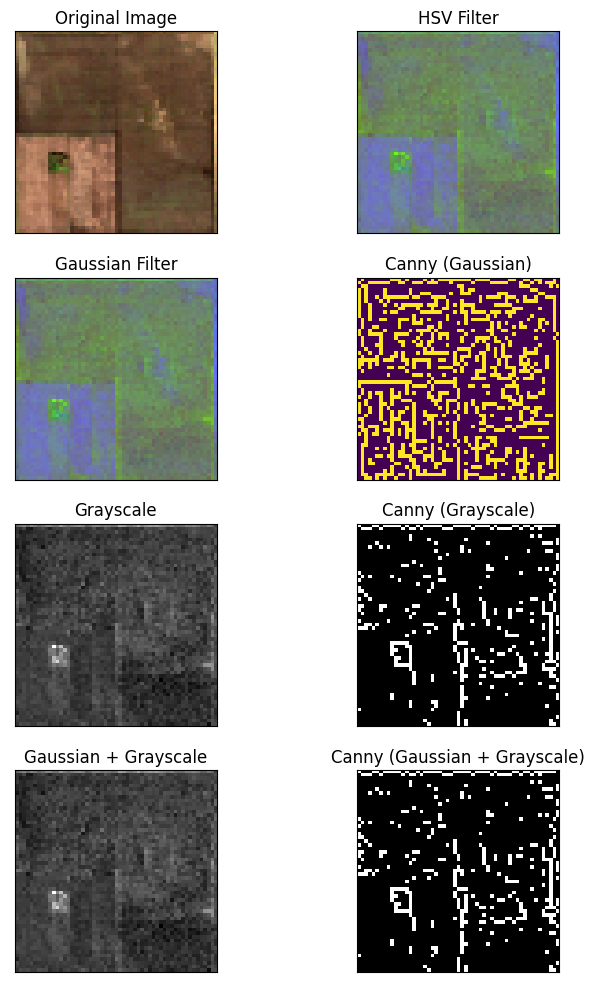

In [5]:
image, hsv_filter, grayscale_filter, gaussian_filter, grayscale_gaussian_filter, grayscale_canny, gaussian_canny, grayscale_gaussian_canny = edge_detection_preprocessing(images[img_keys[0]], 50, 50)

visualize_edge_detection(image, hsv_filter, grayscale_filter, gaussian_filter, grayscale_gaussian_filter, grayscale_canny, gaussian_canny, grayscale_gaussian_canny)

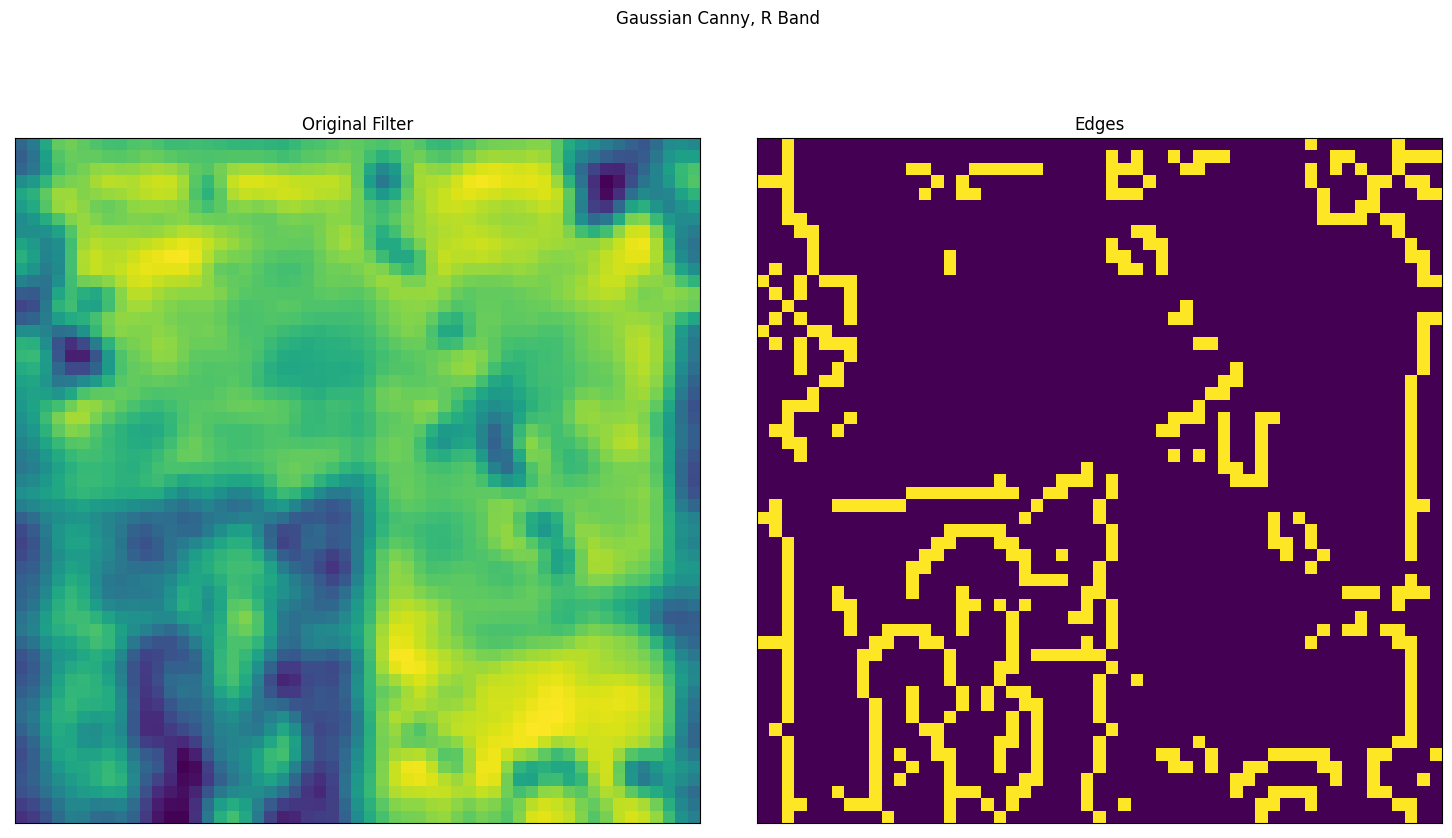

In [6]:
image, gaussian_filter, gaussian_canny = edge_detection_preprocessing(images[img_keys[0]], 150, 150, "B")
visualize_filter_edges(gaussian_filter, gaussian_canny, "Gaussian Canny, R Band")

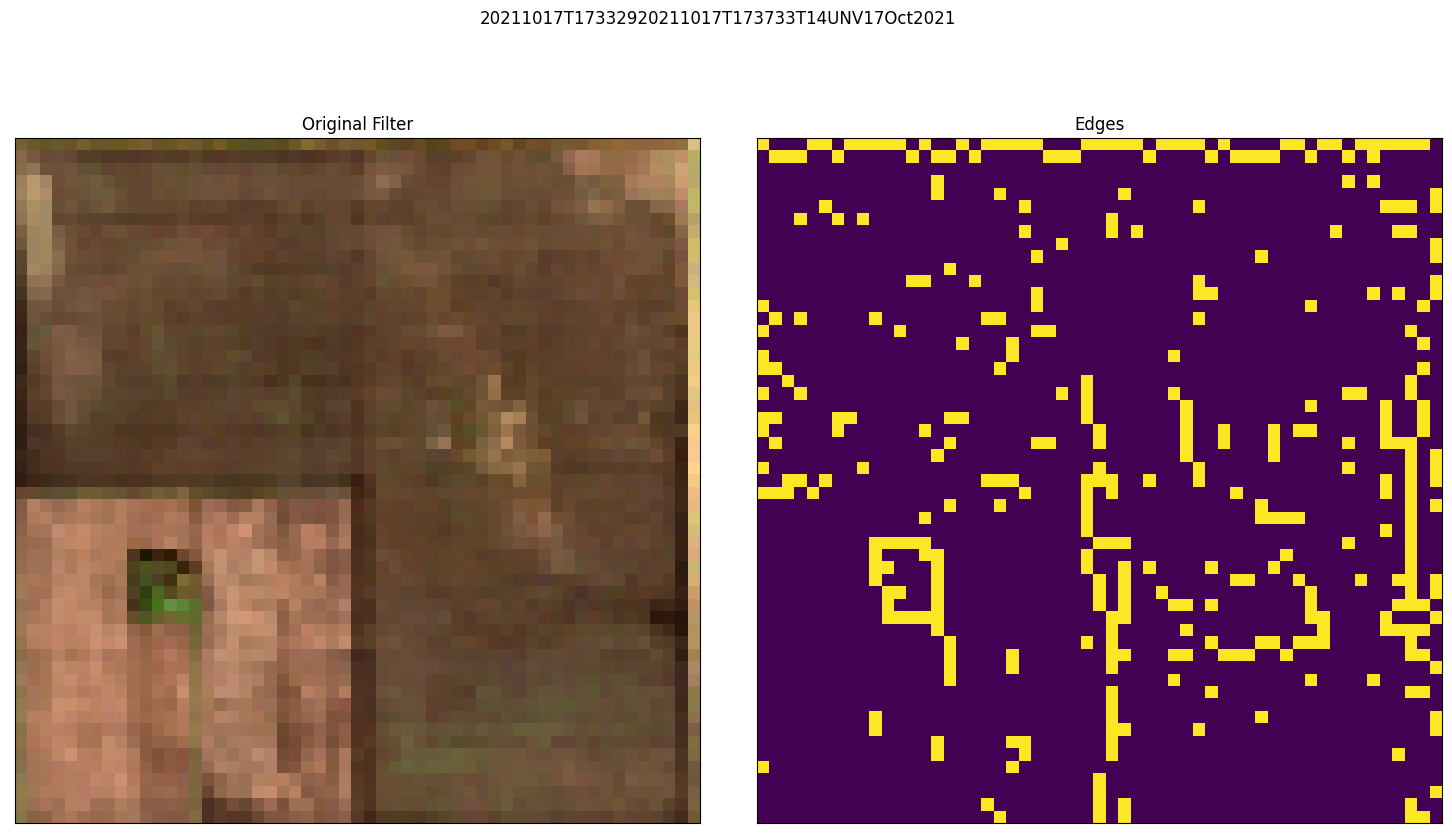

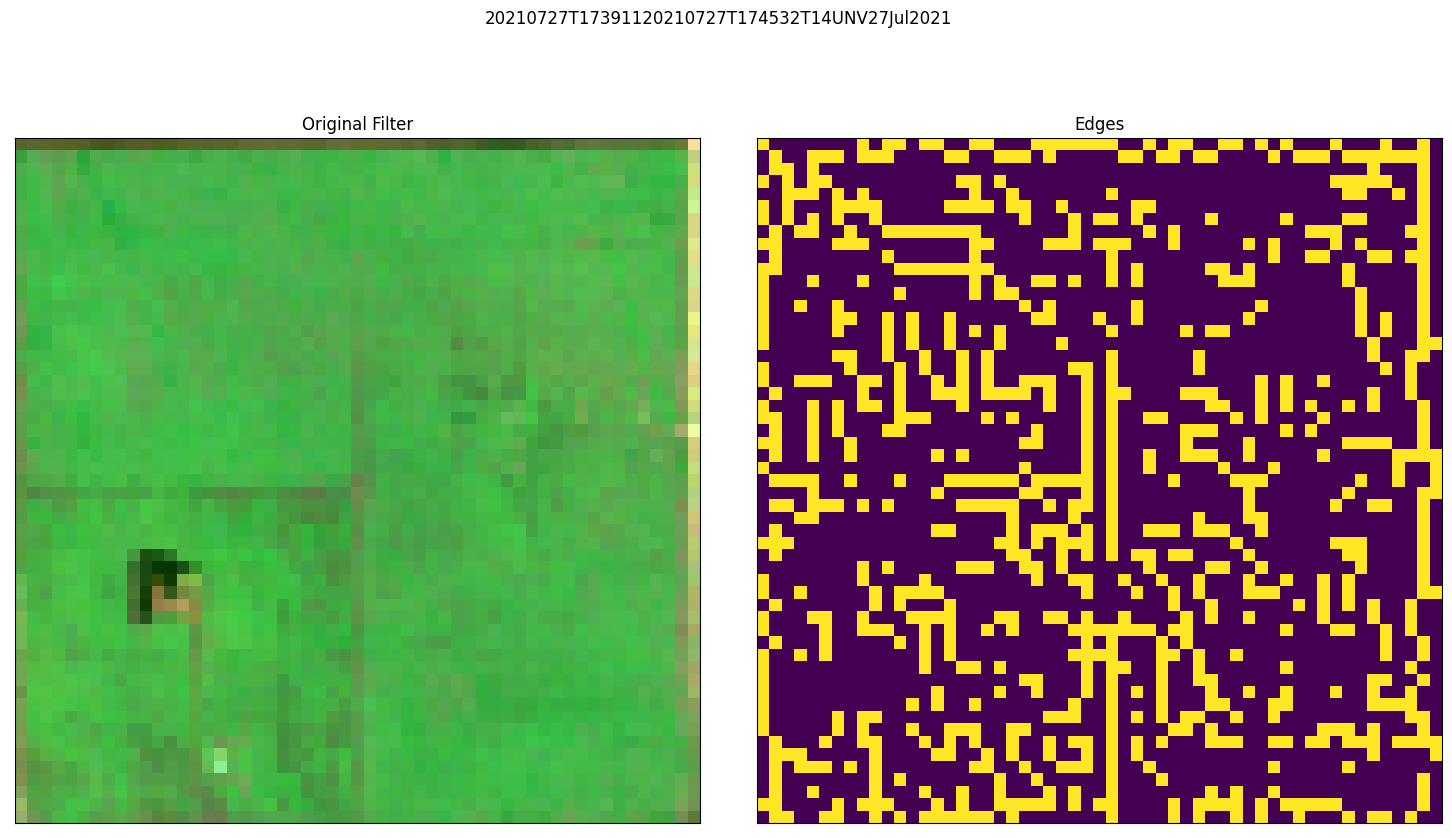

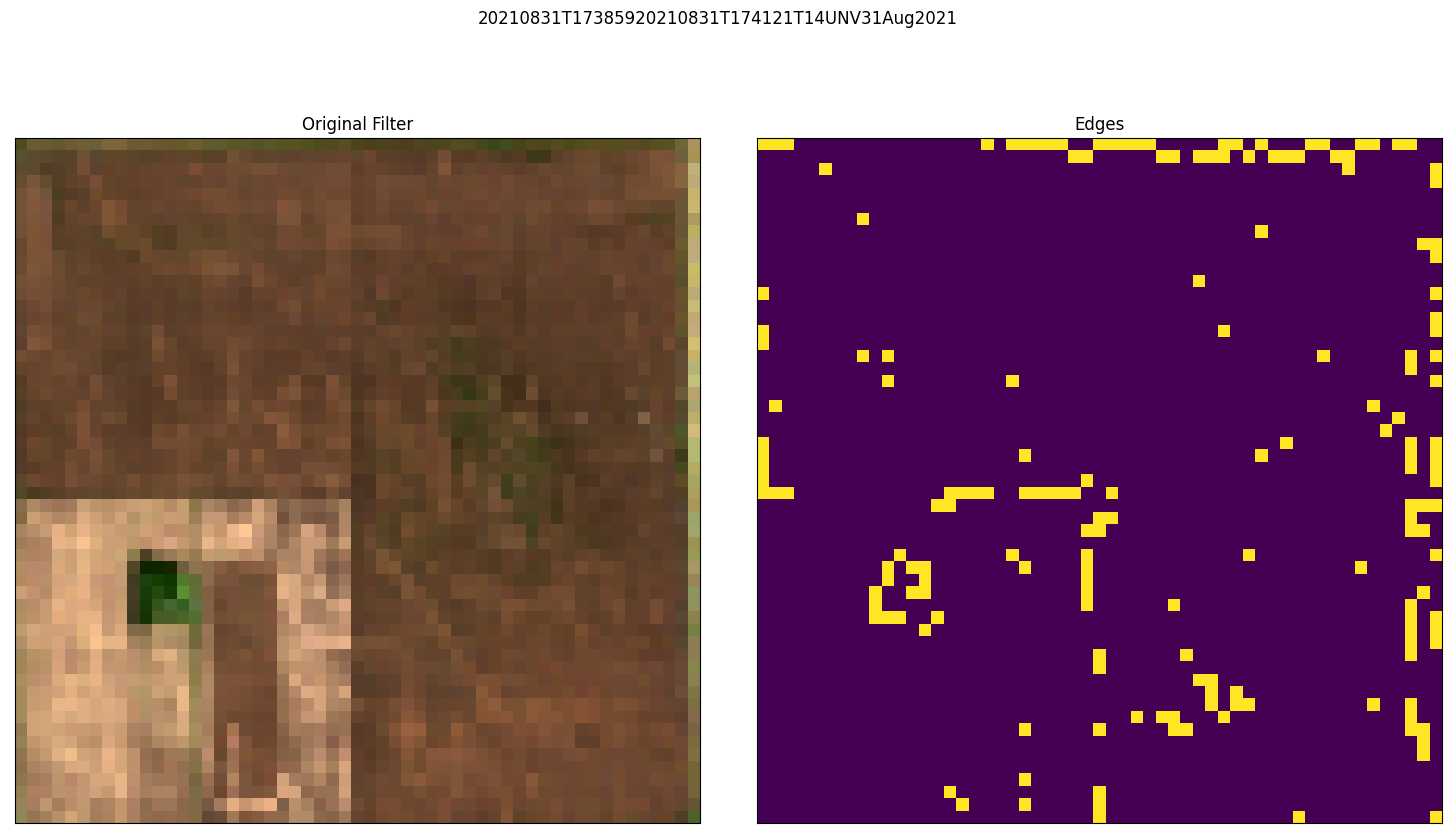

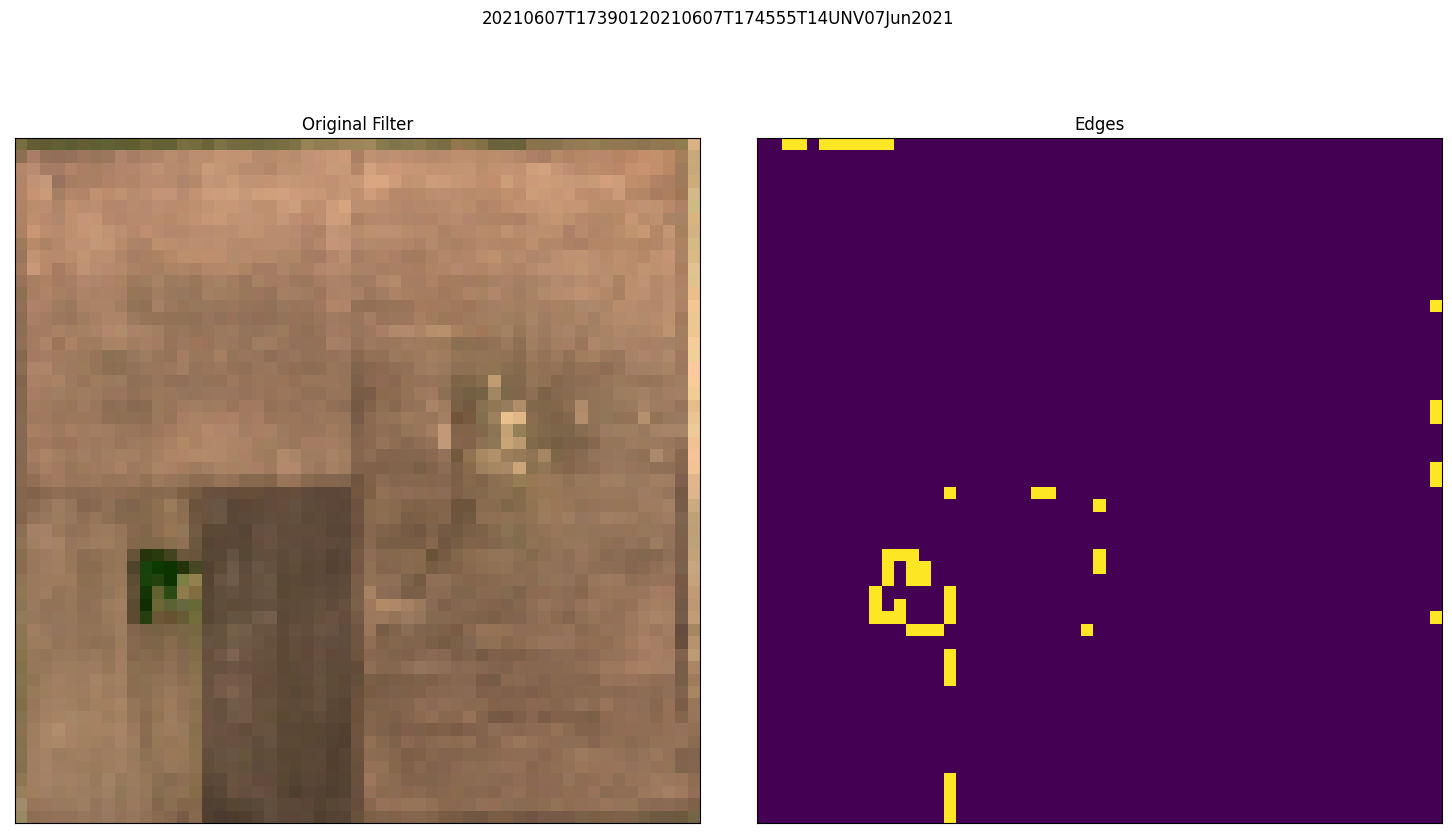

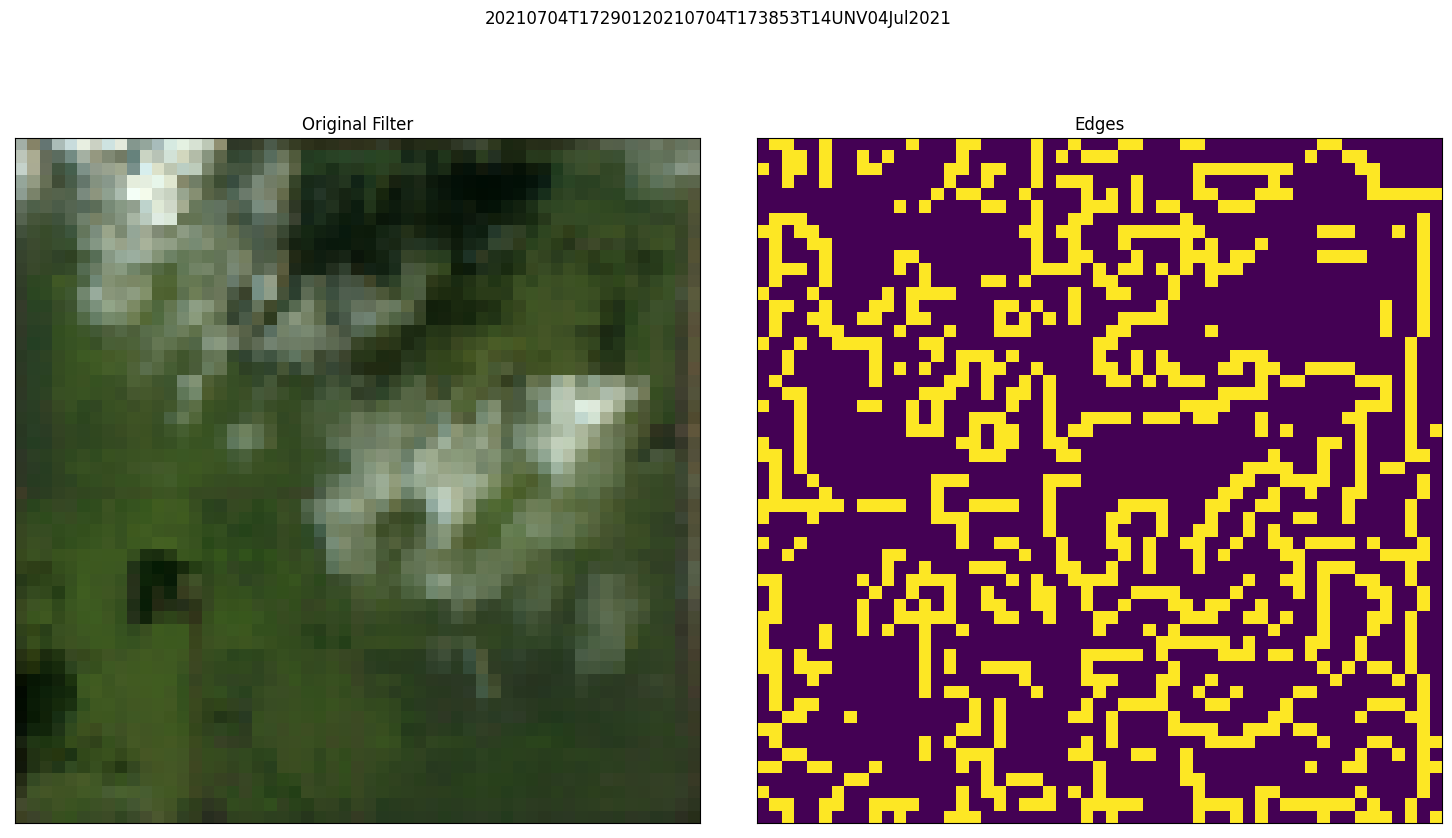

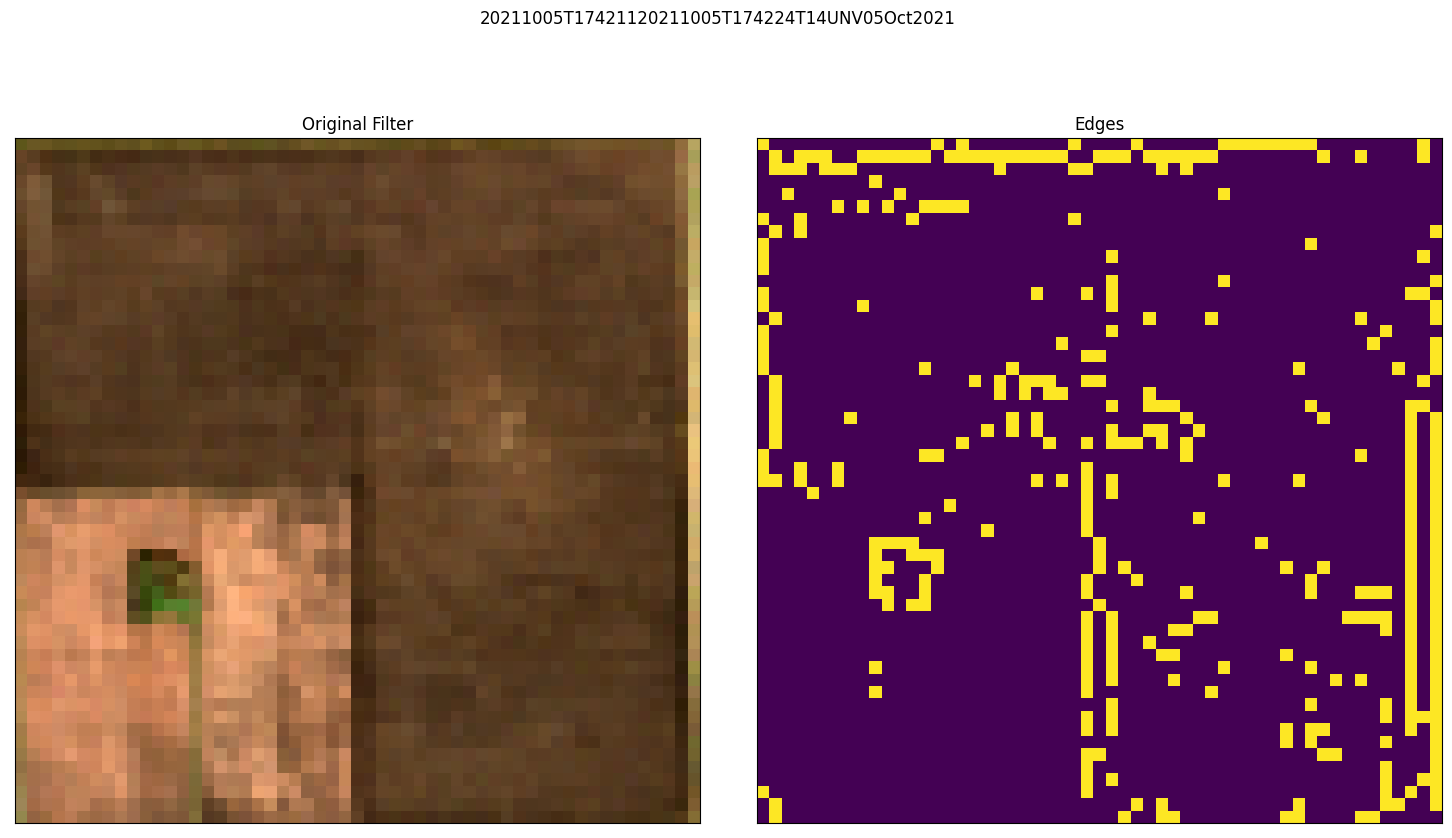

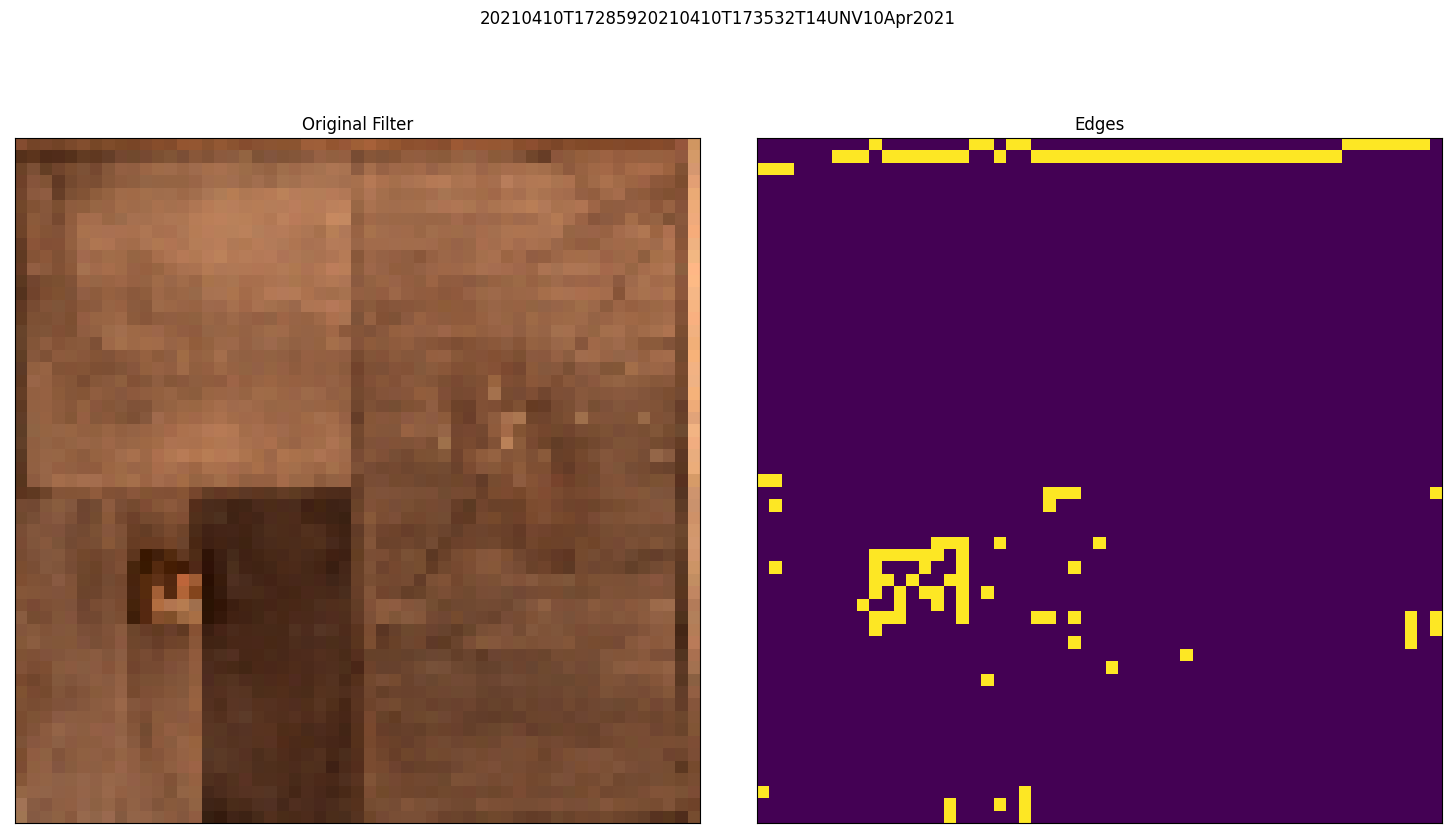

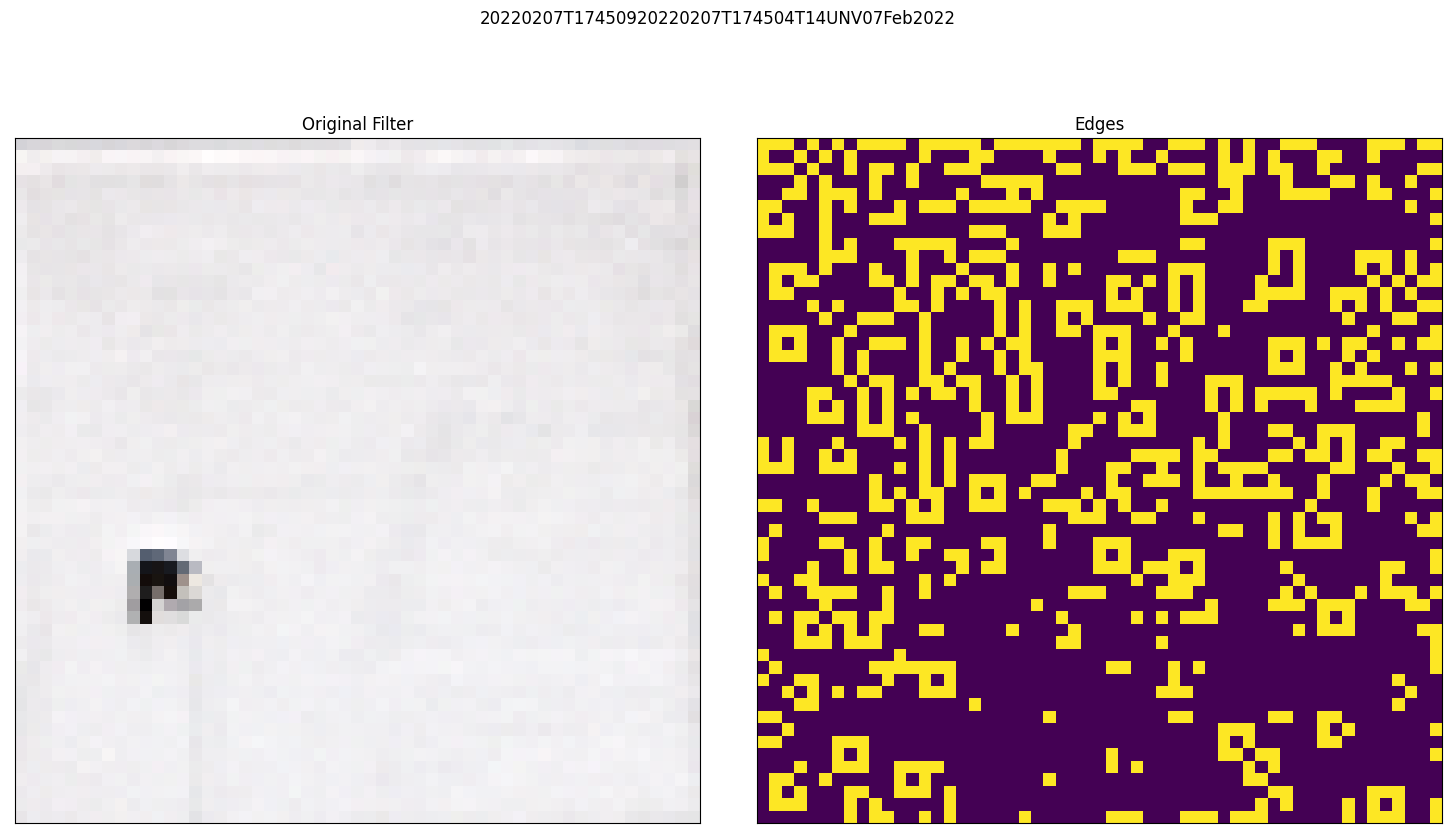

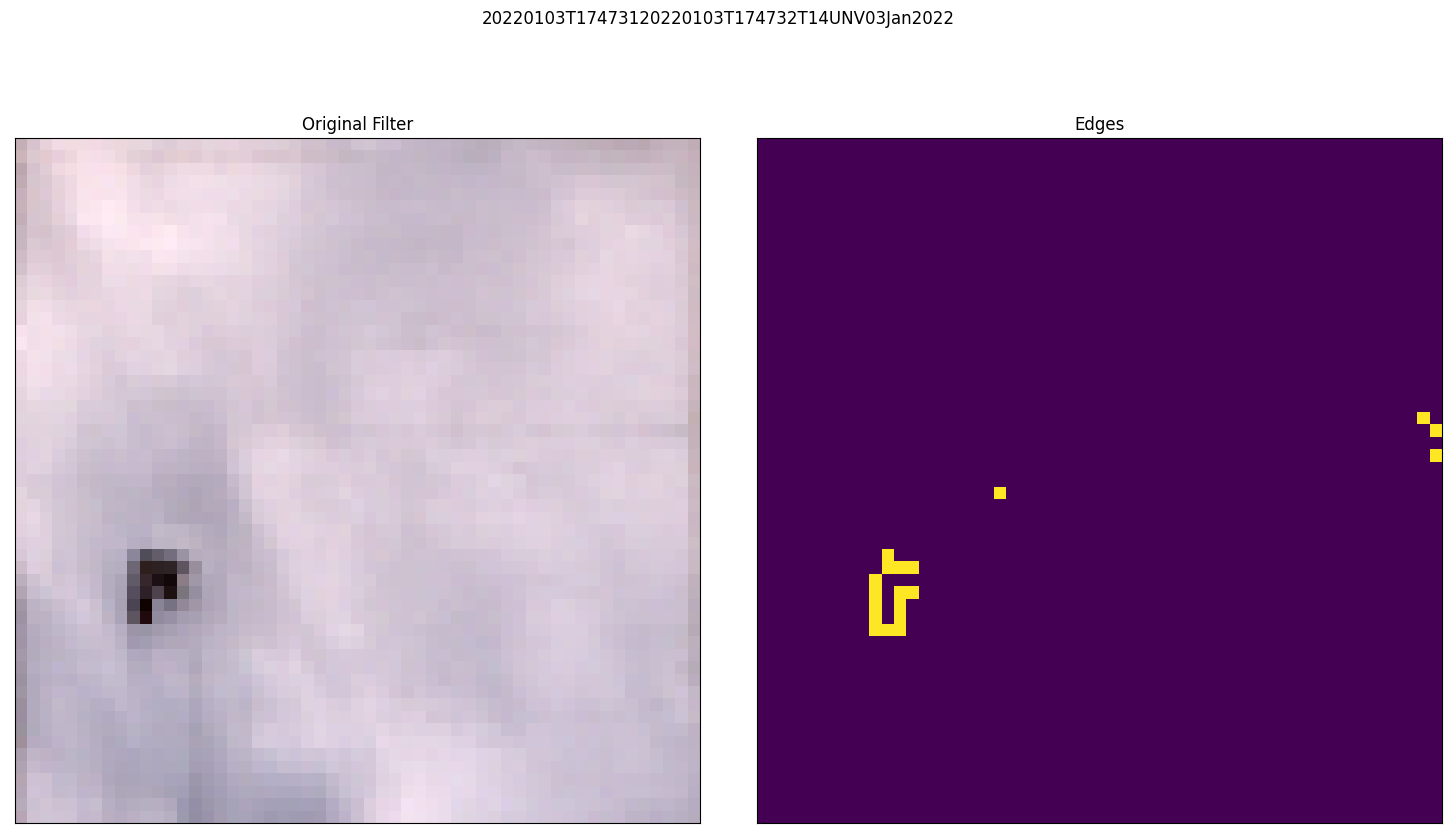

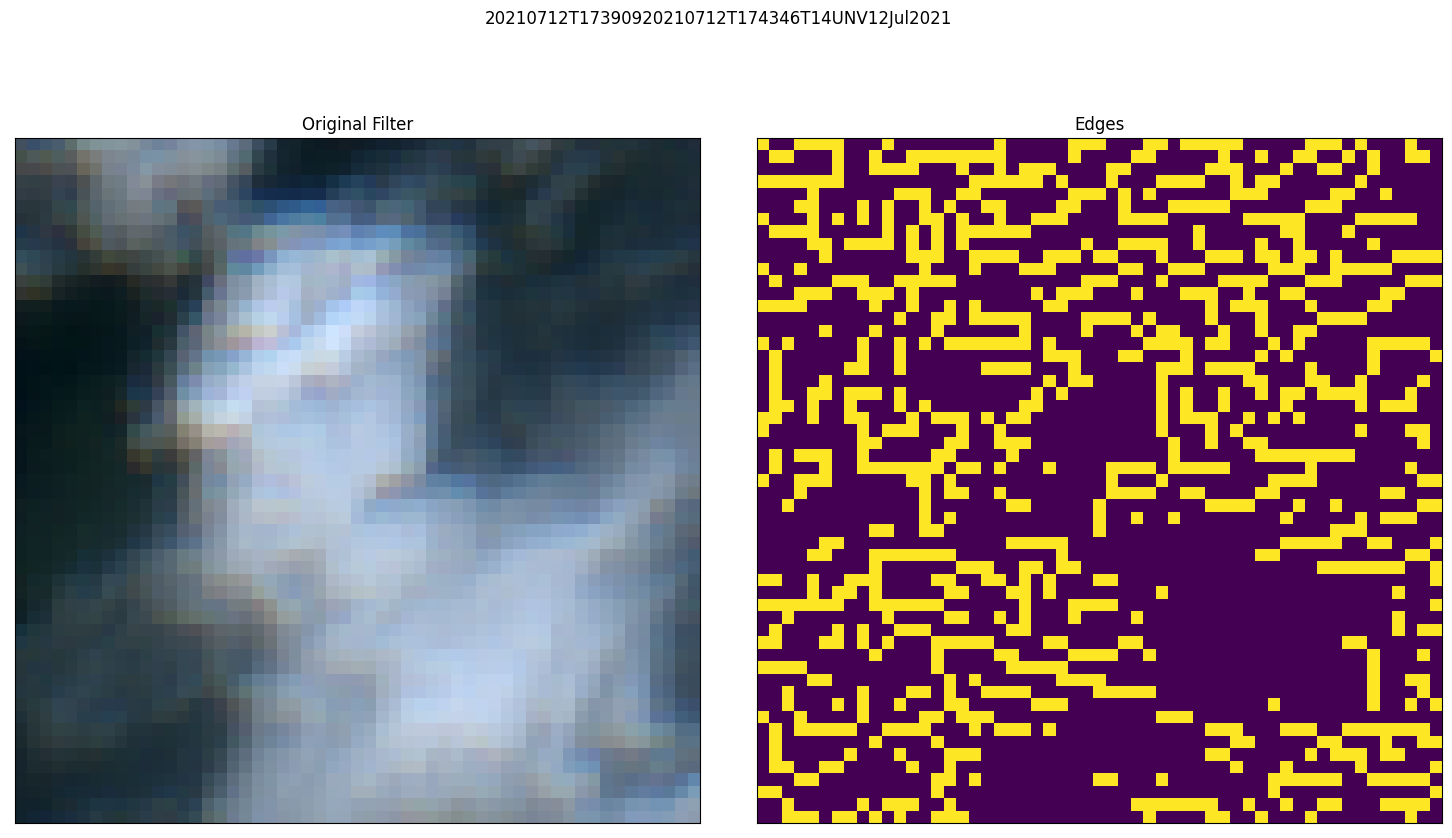

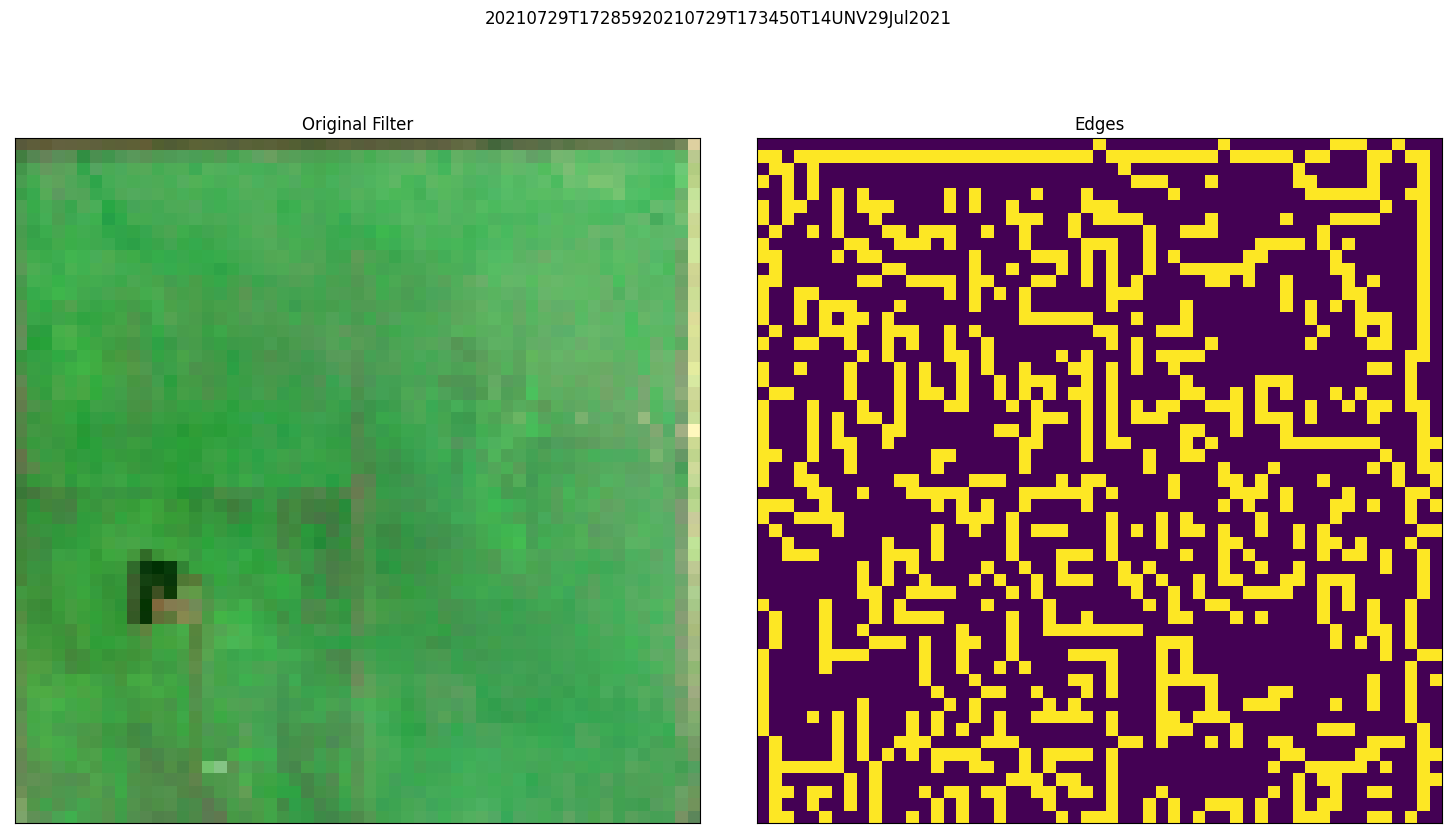

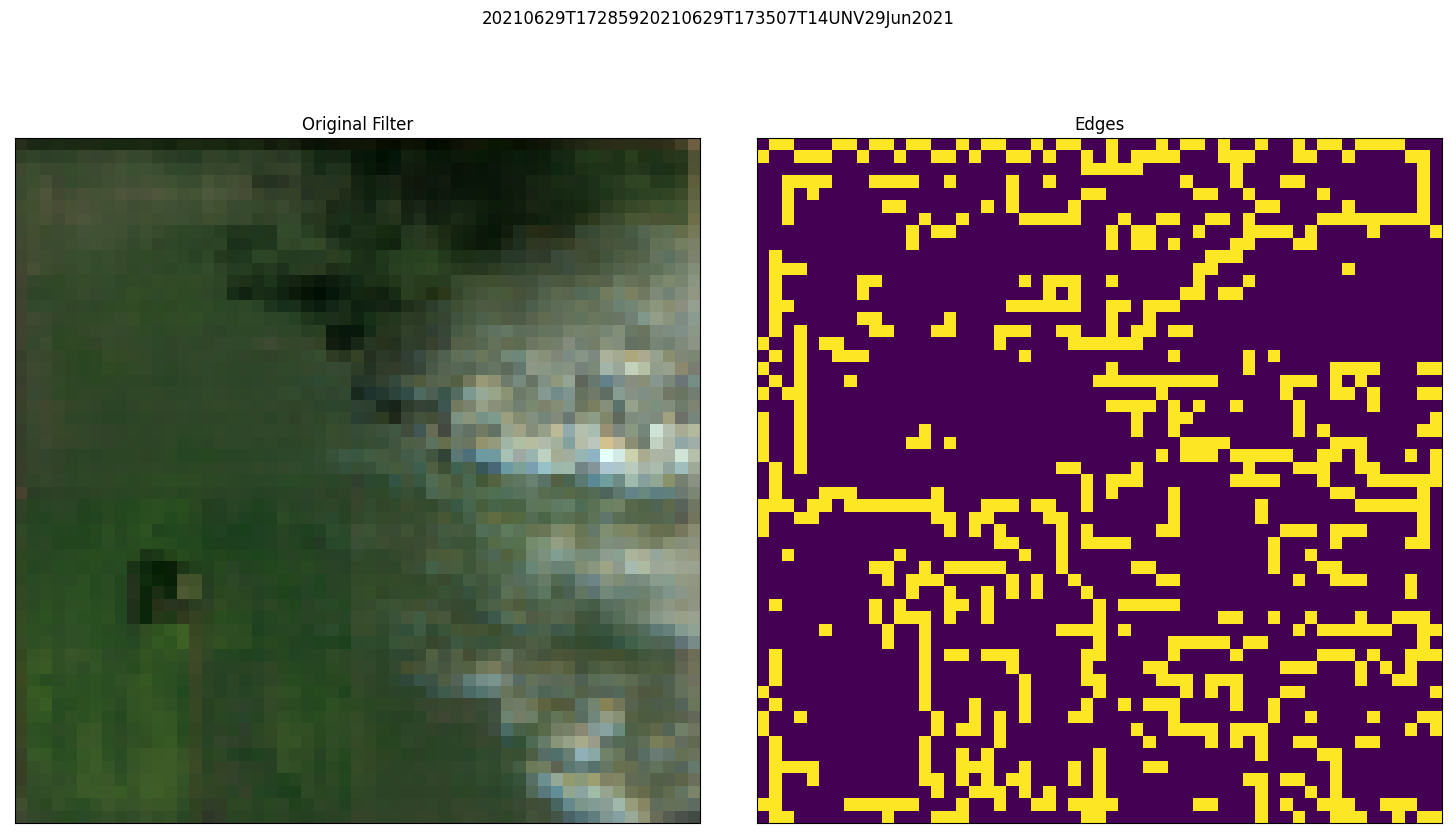

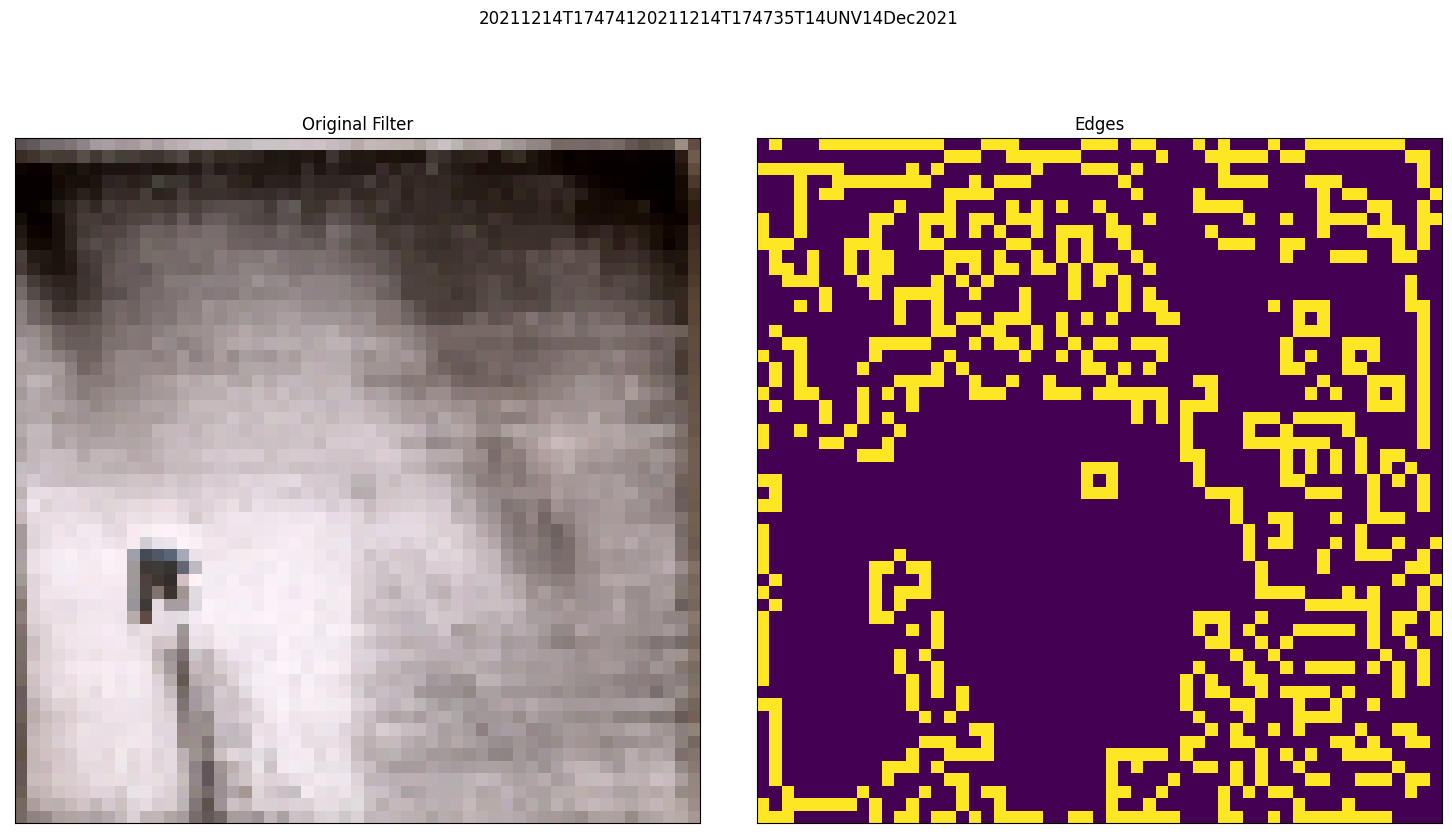

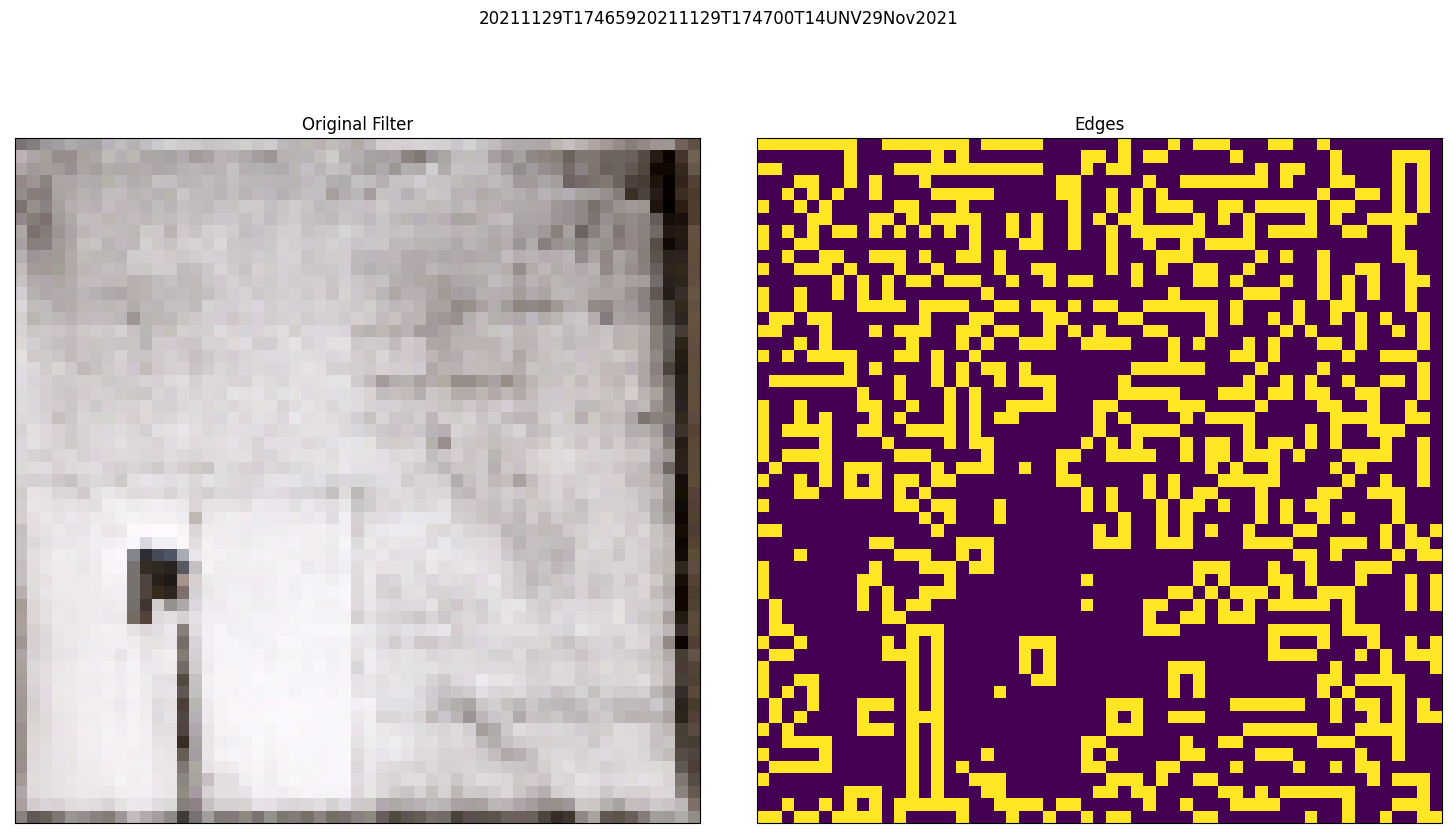

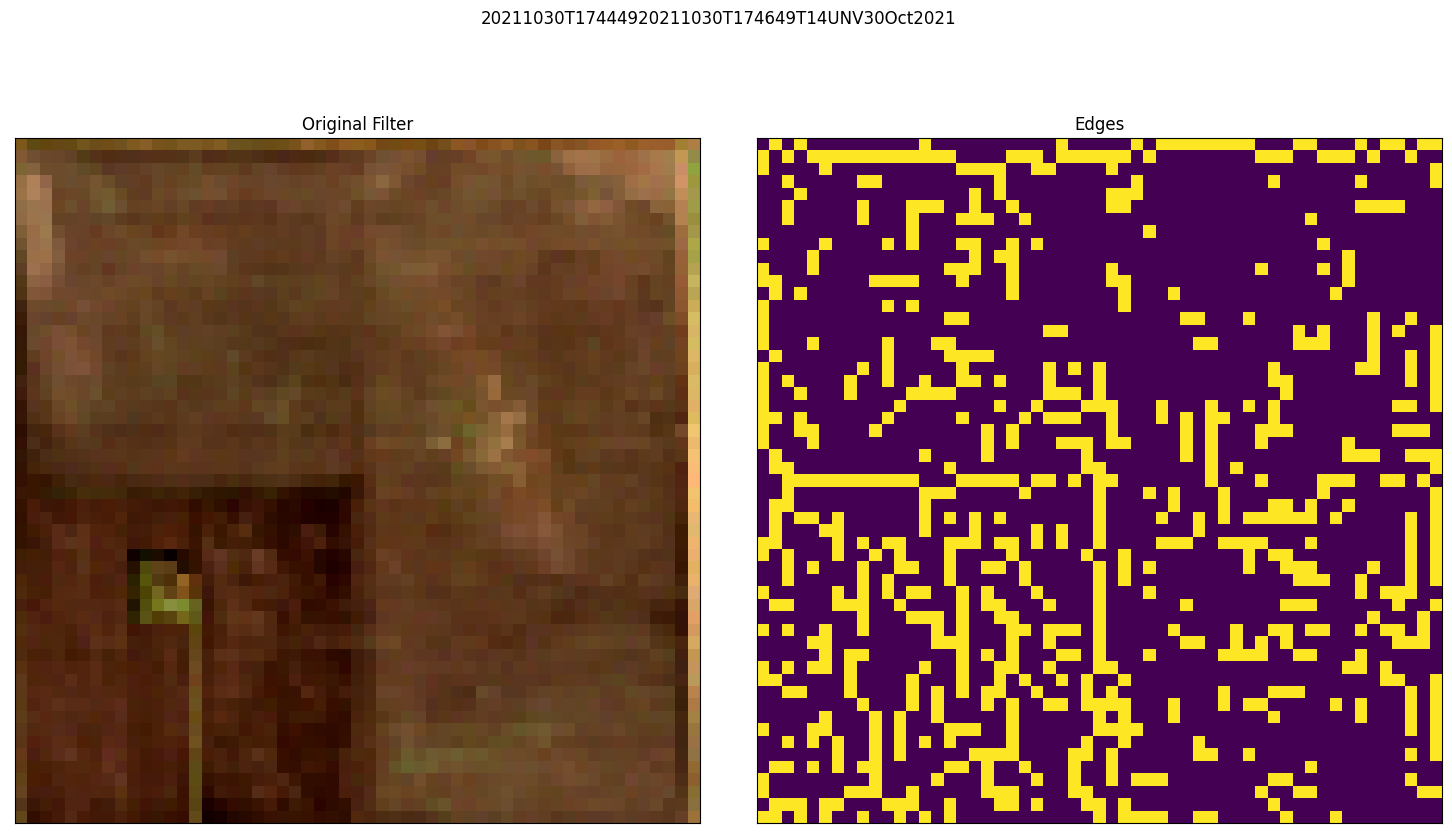

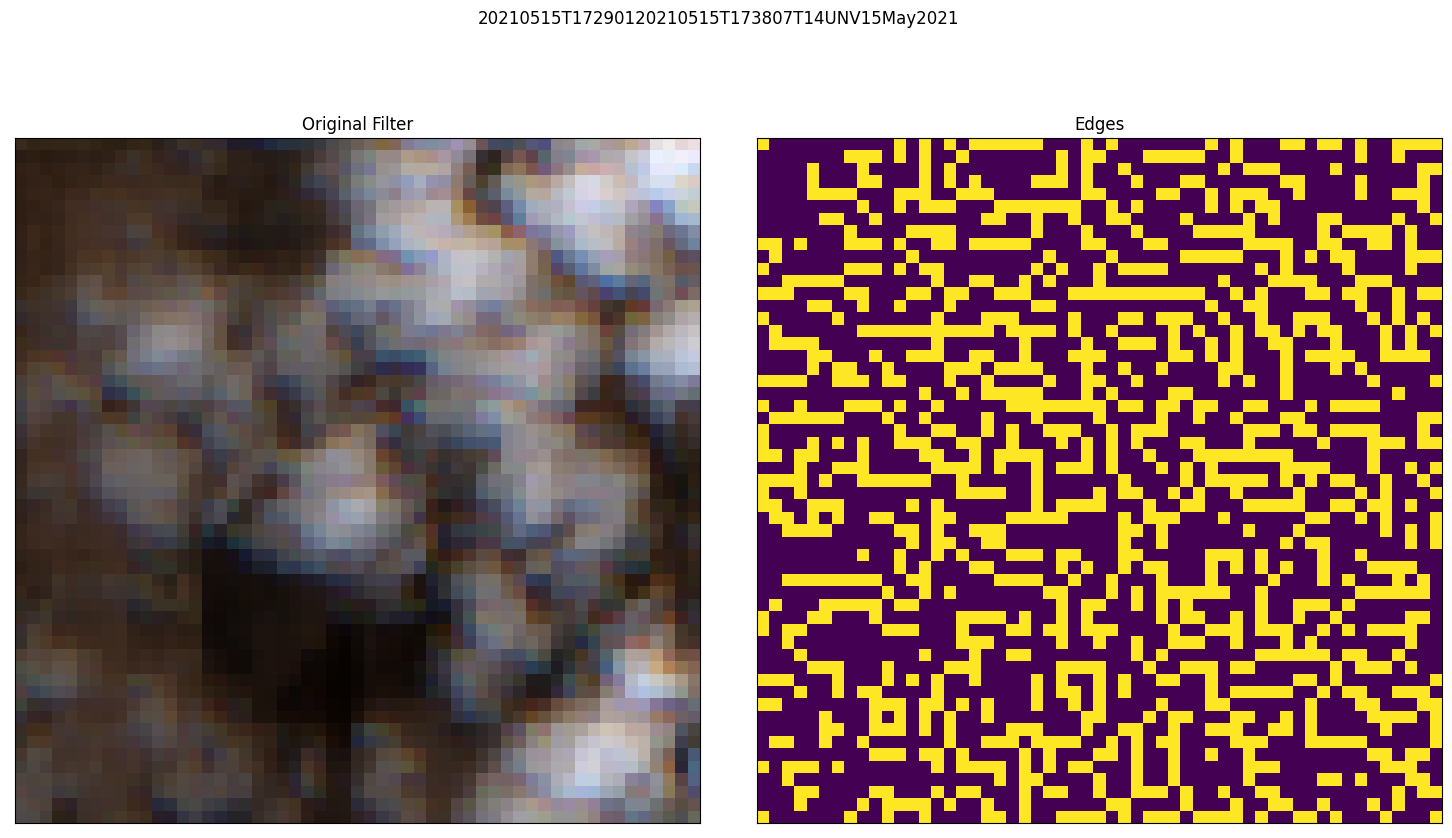

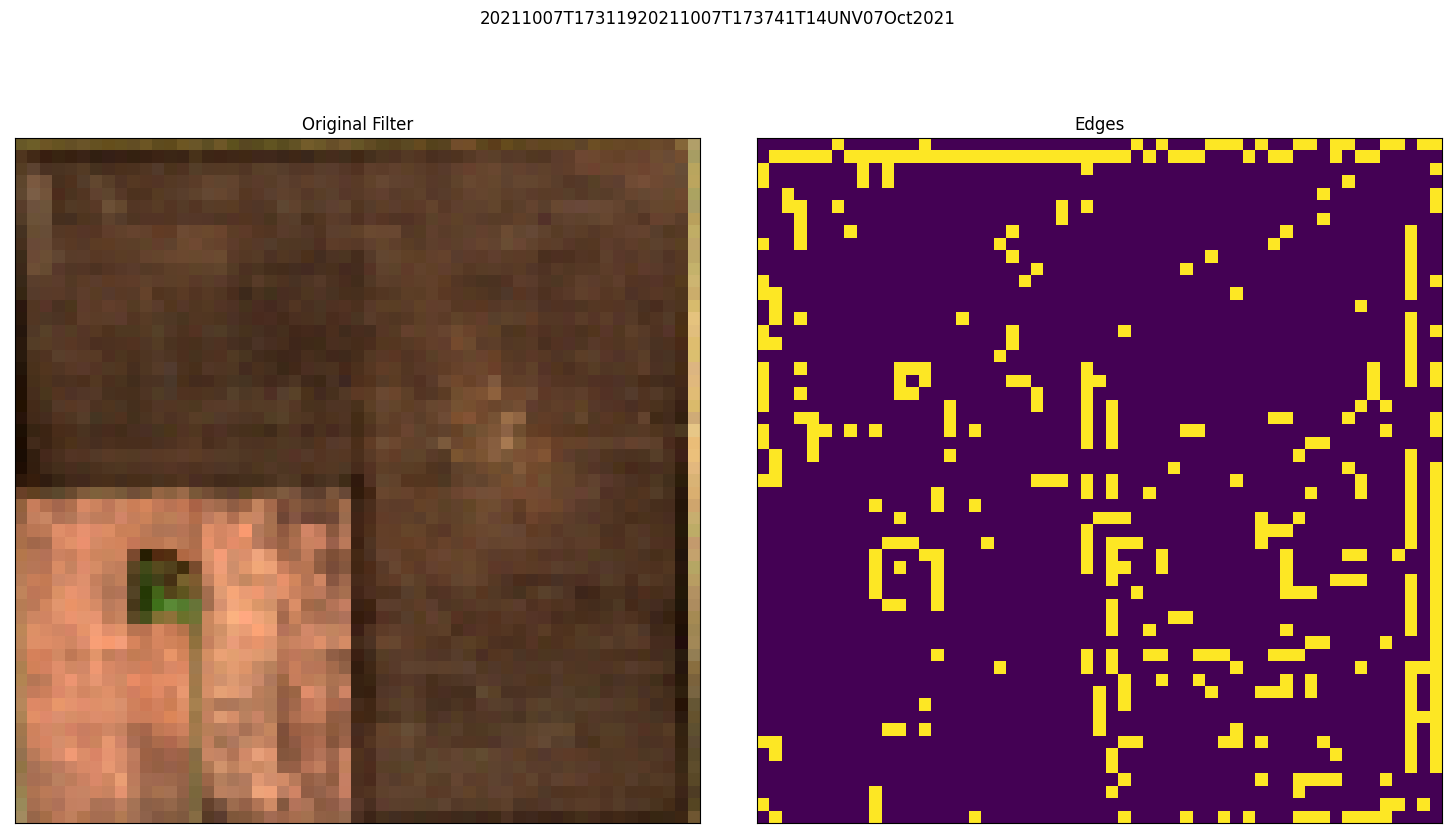

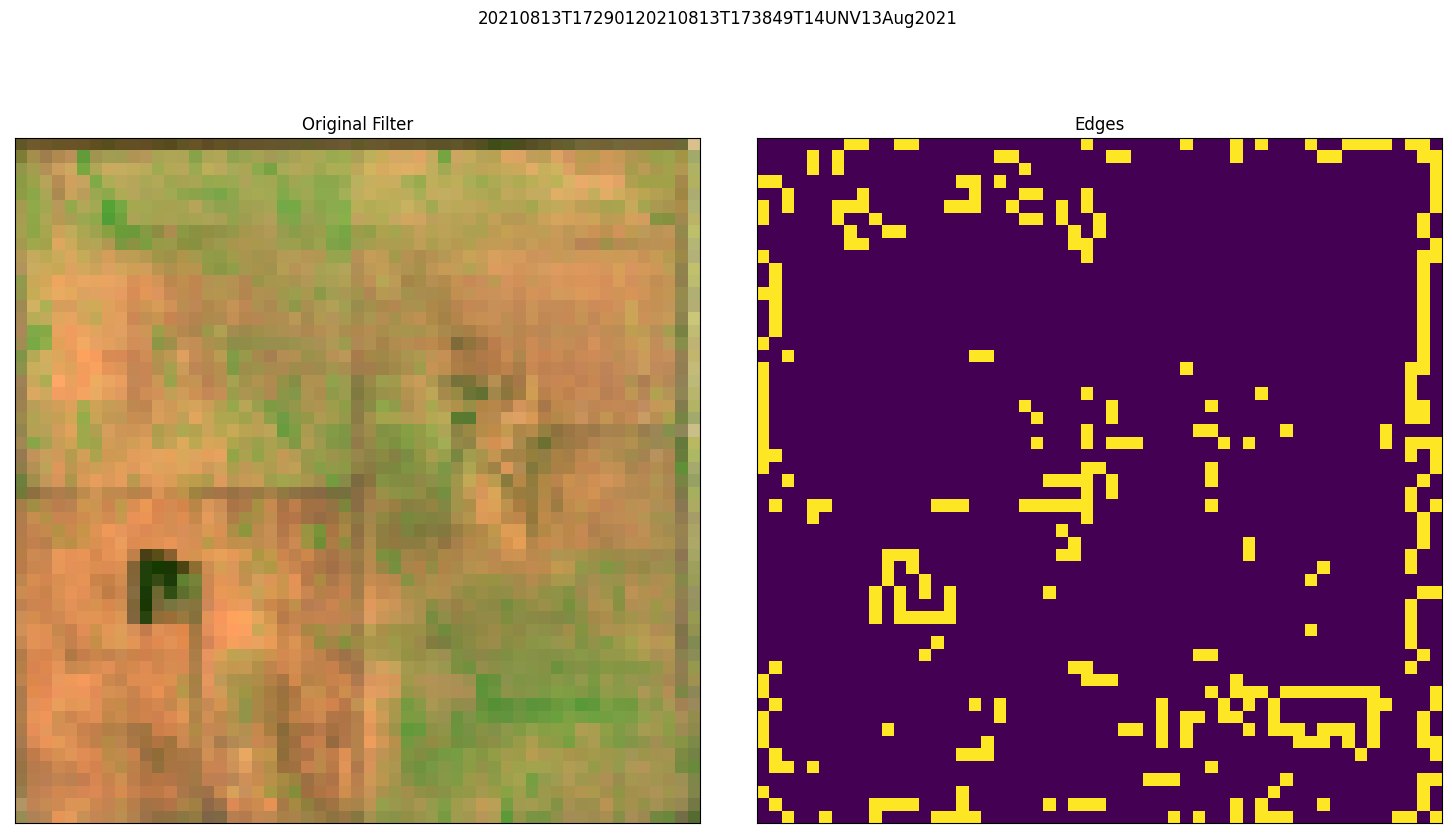

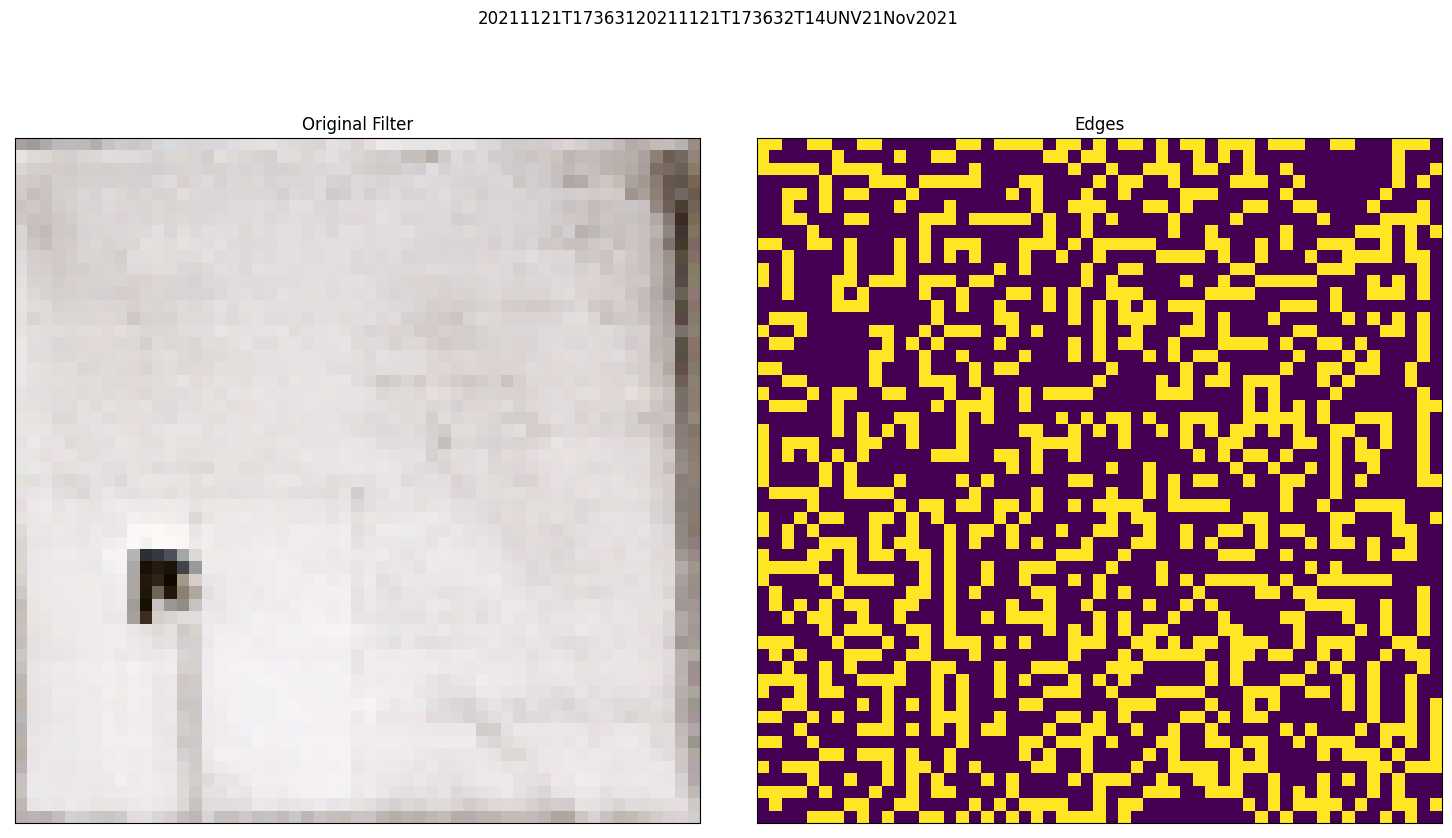

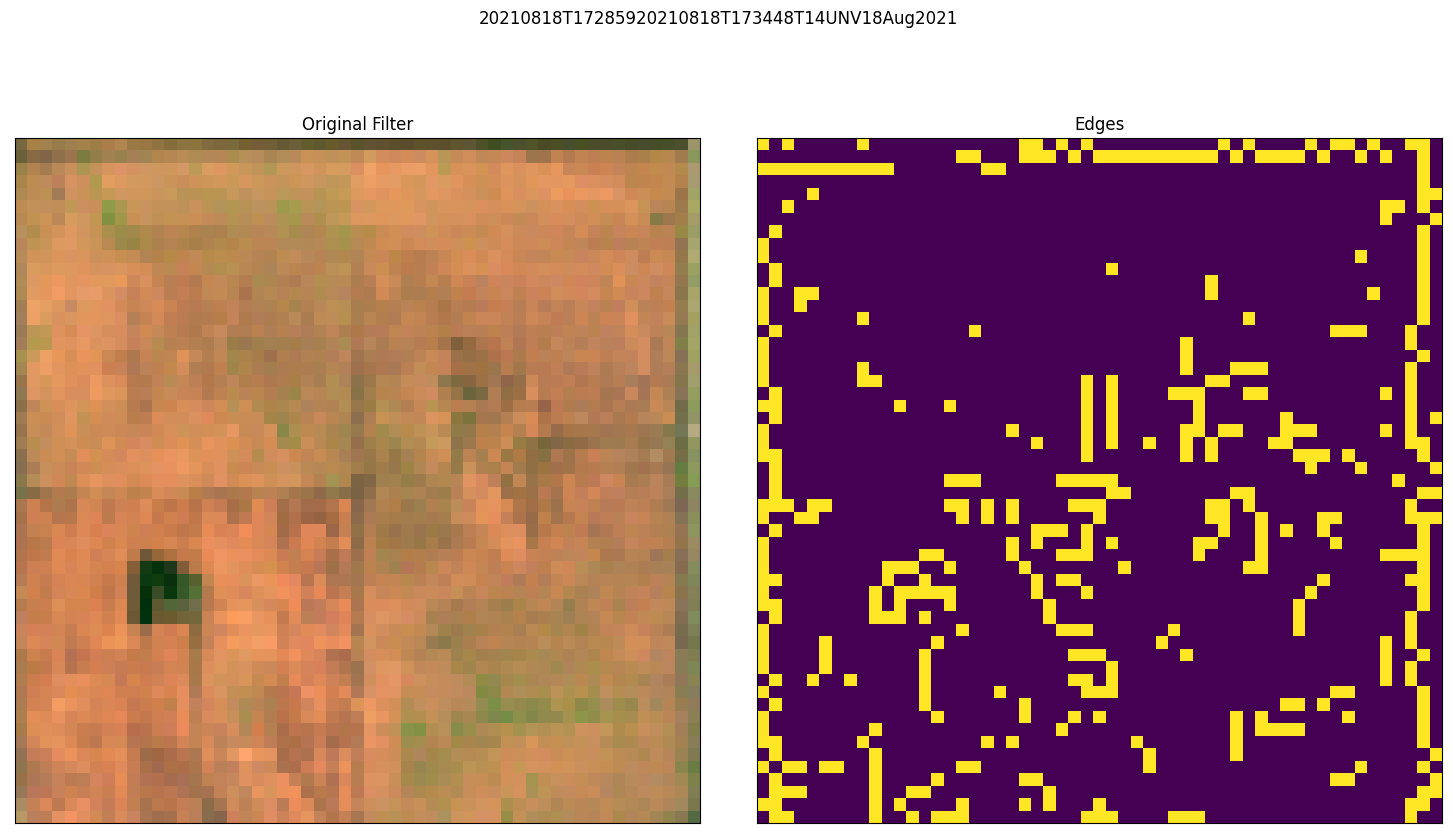

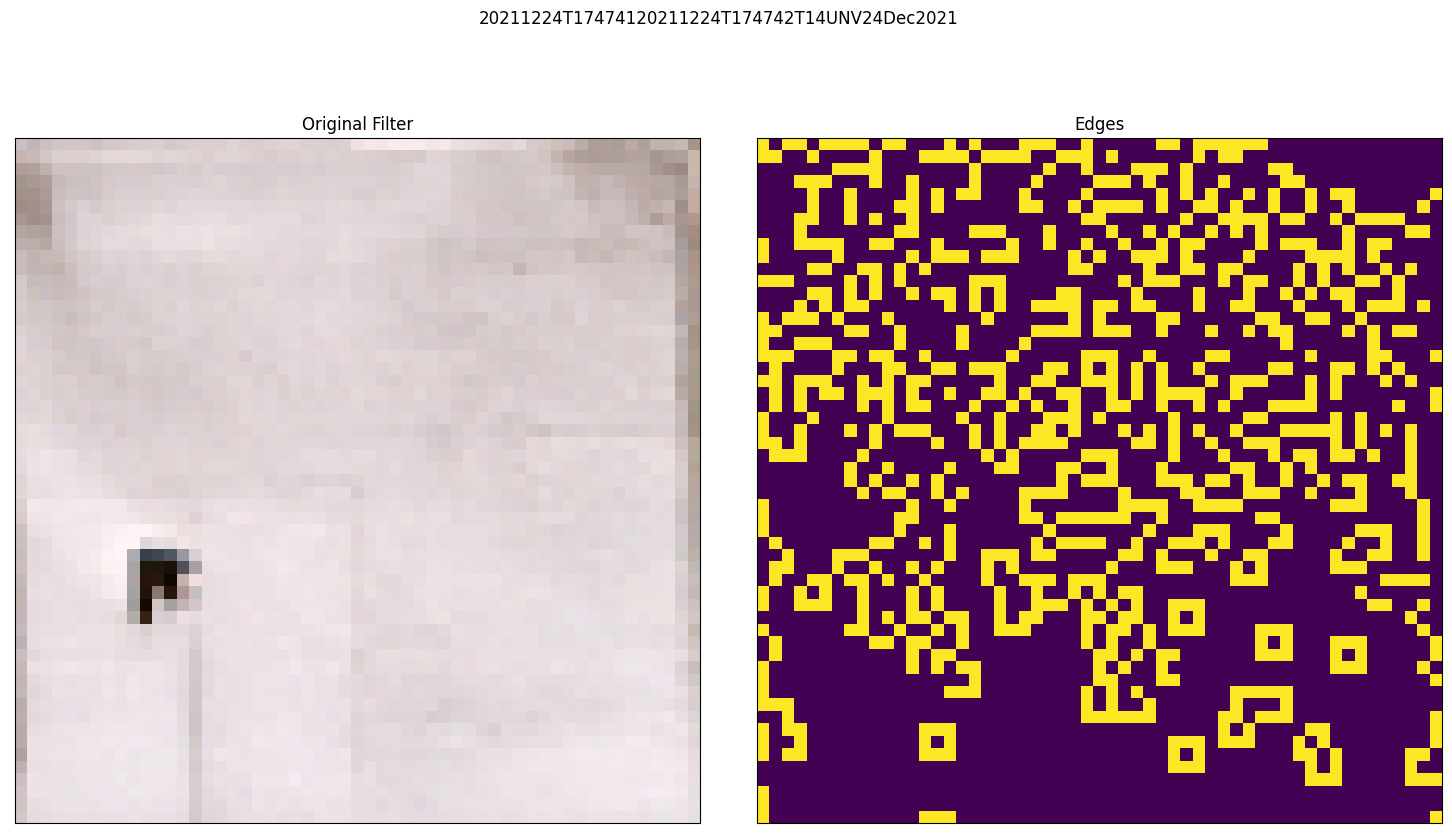

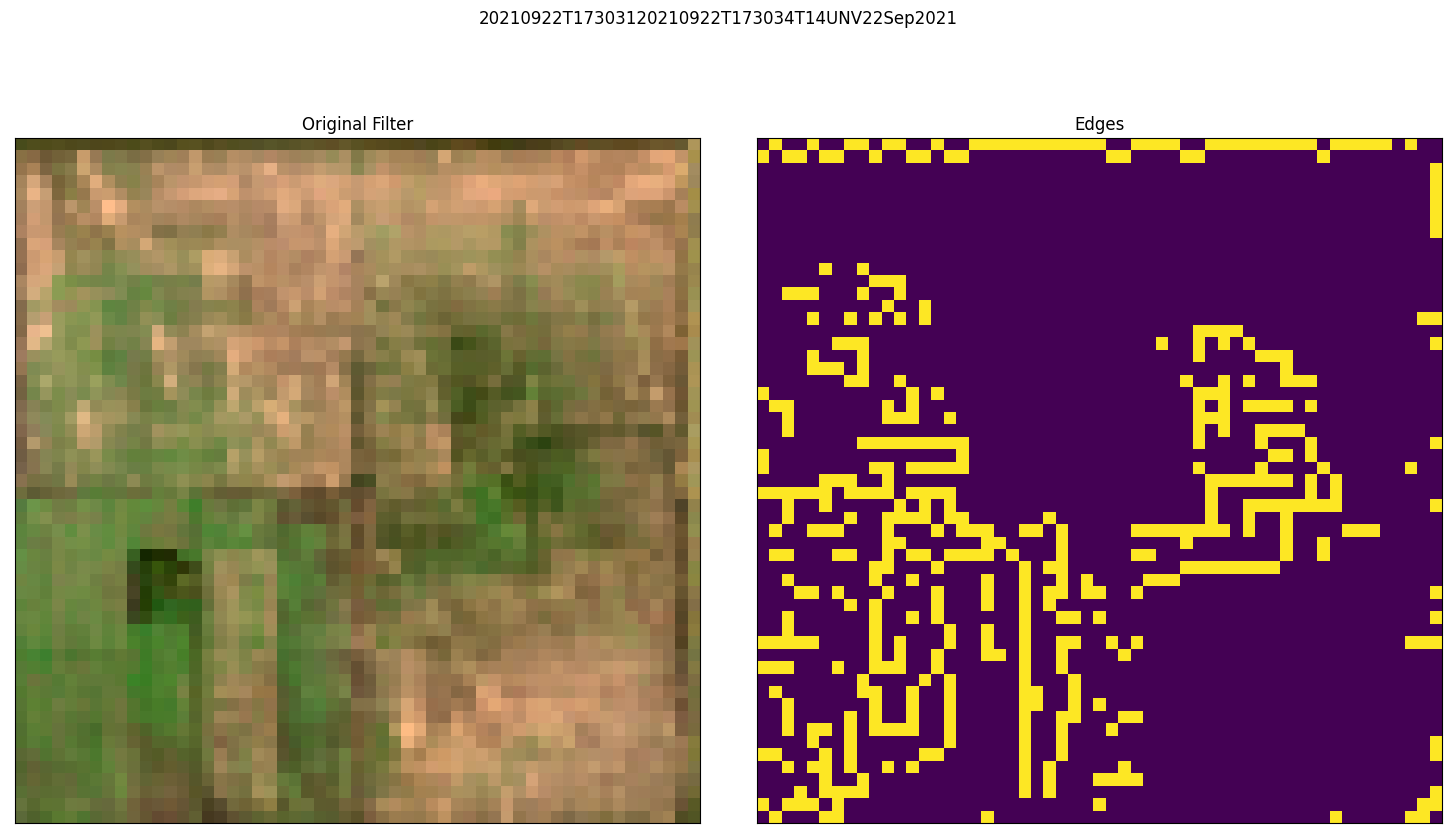

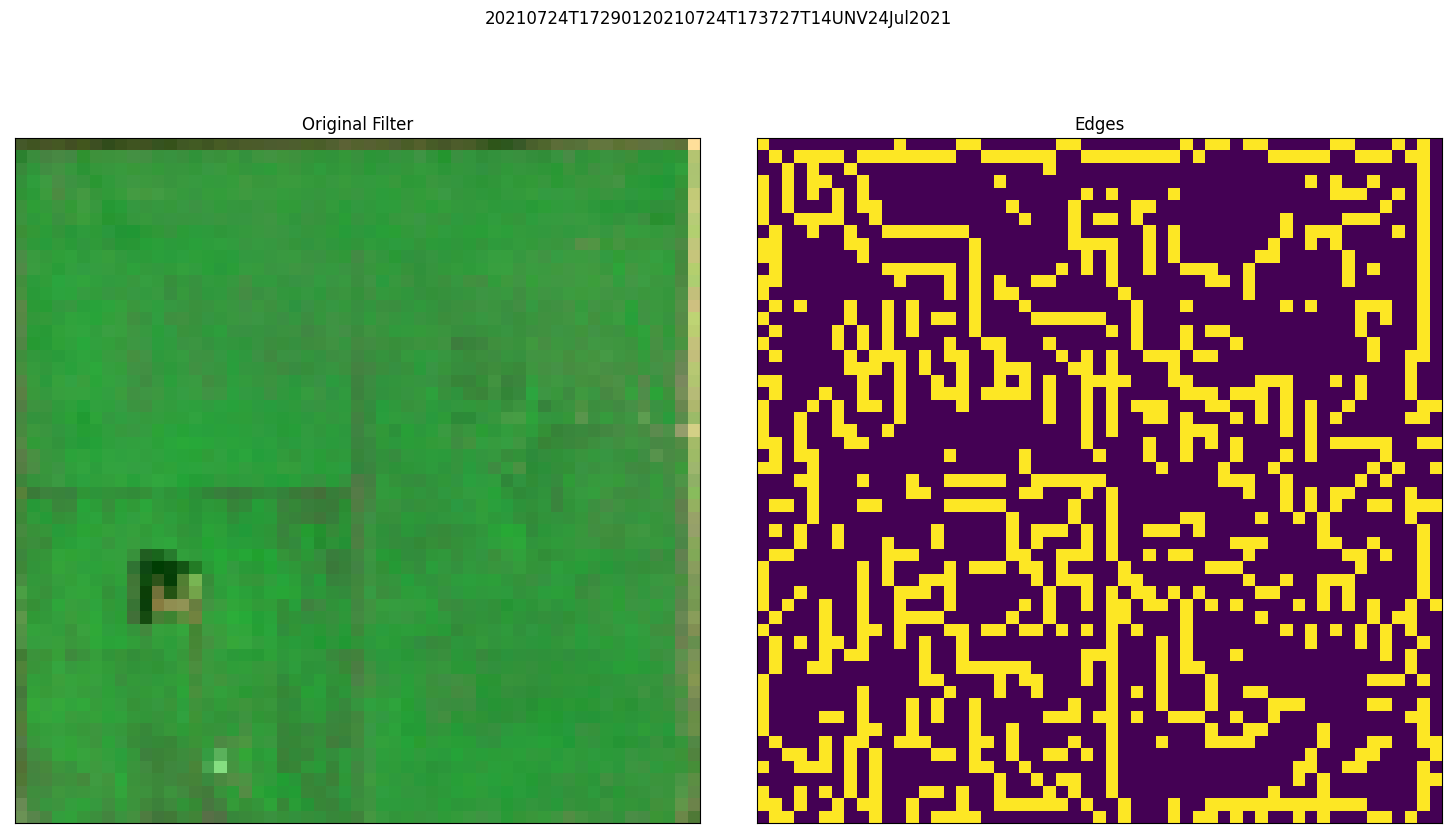

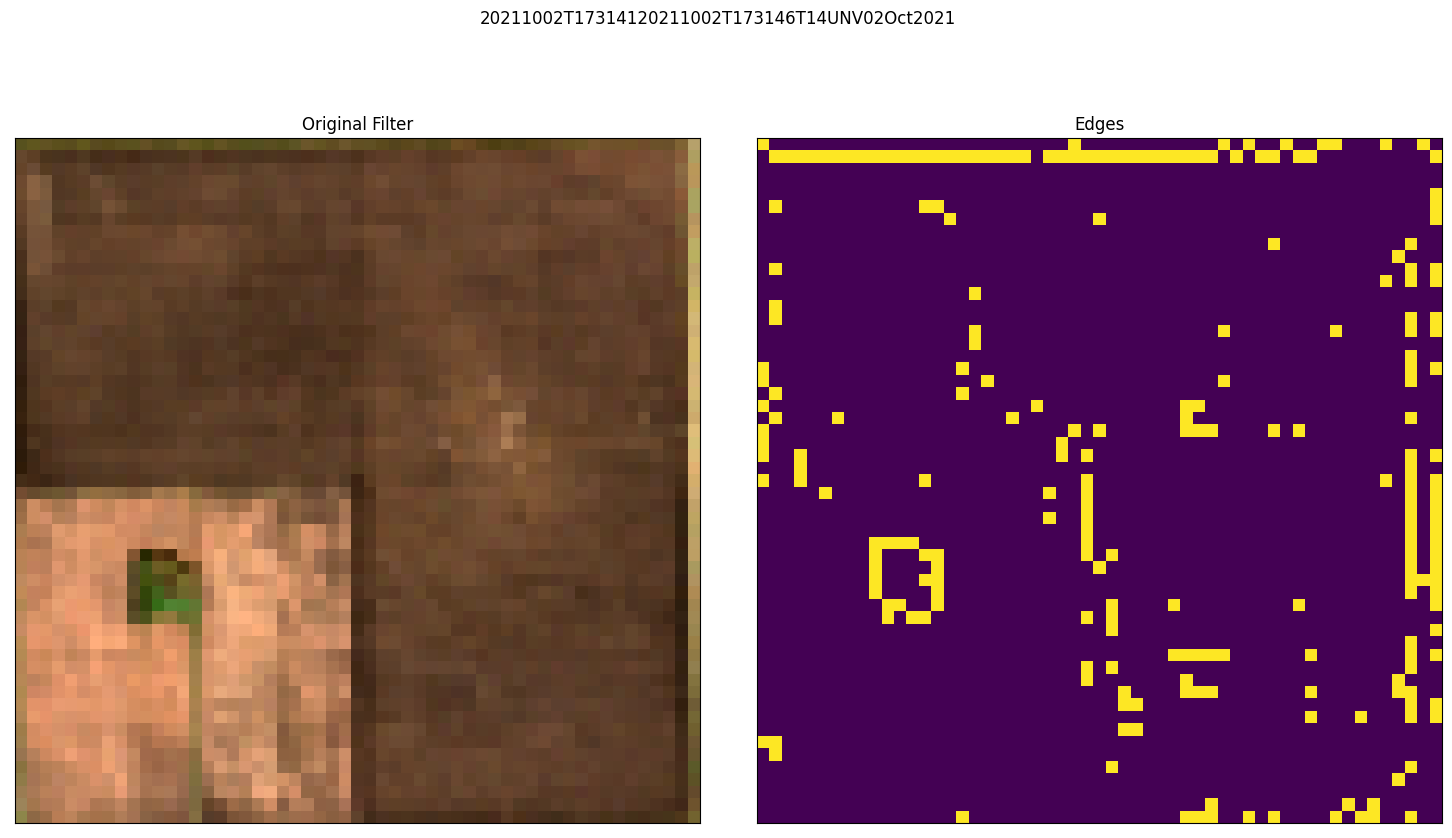

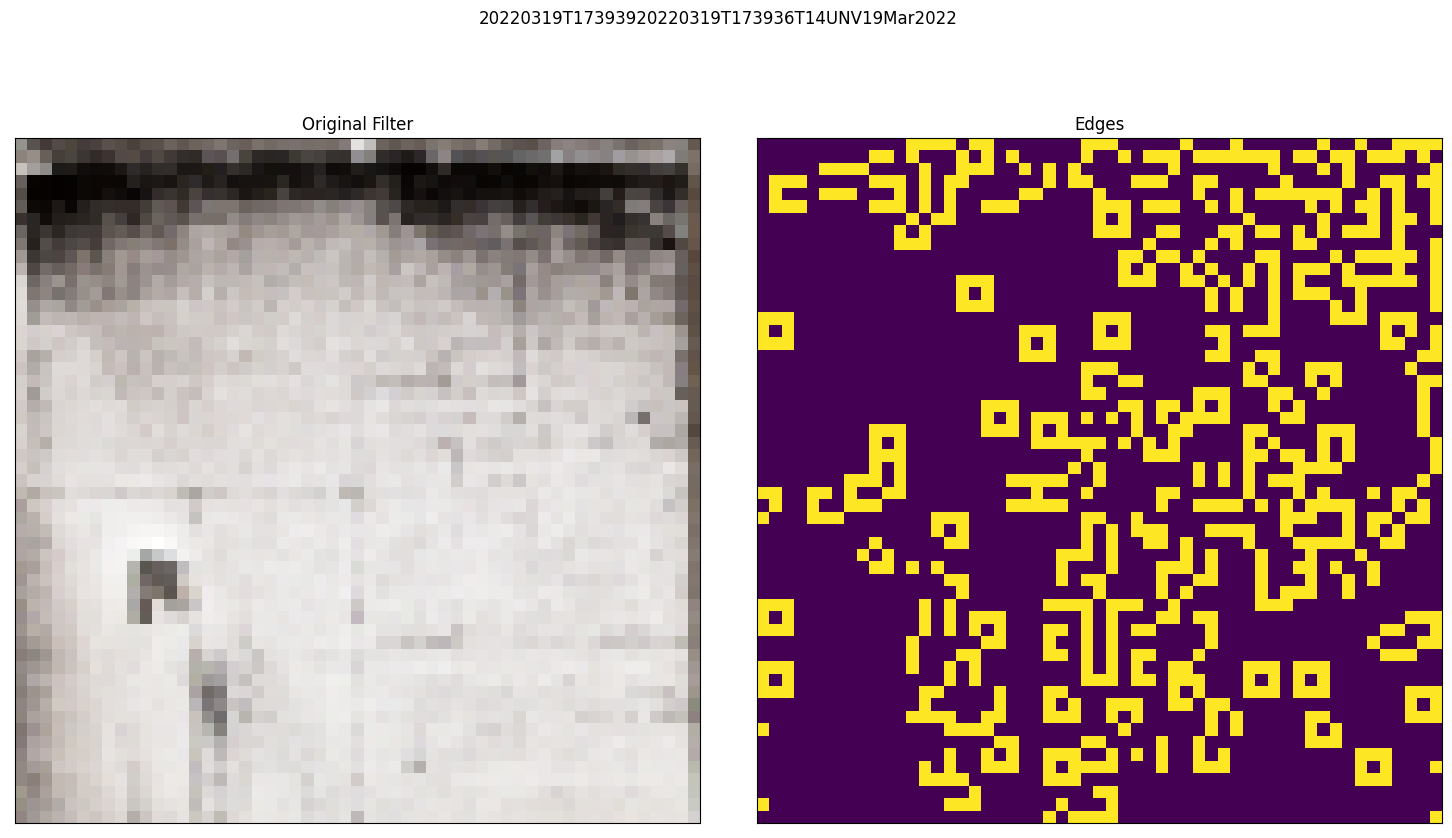

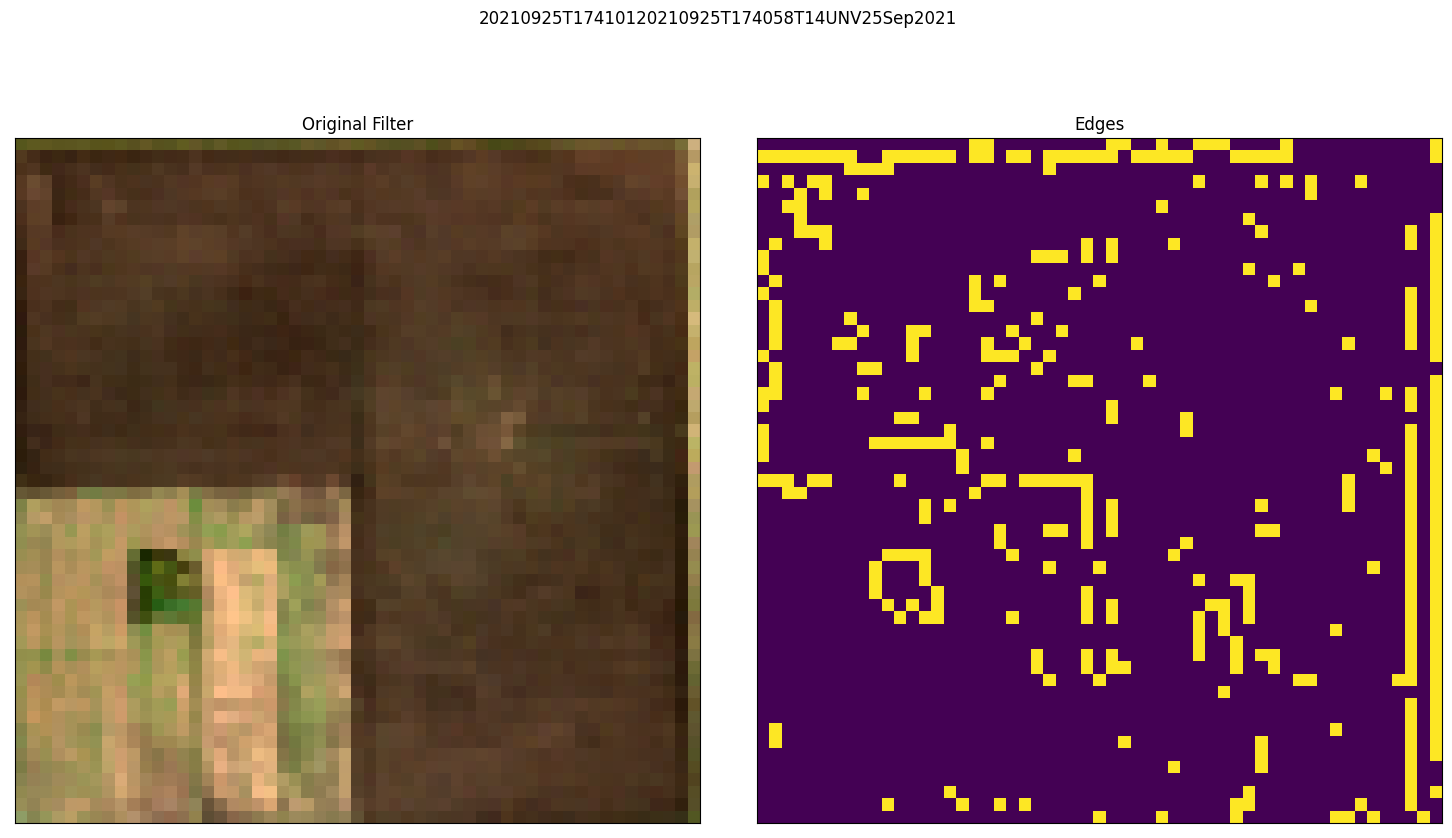

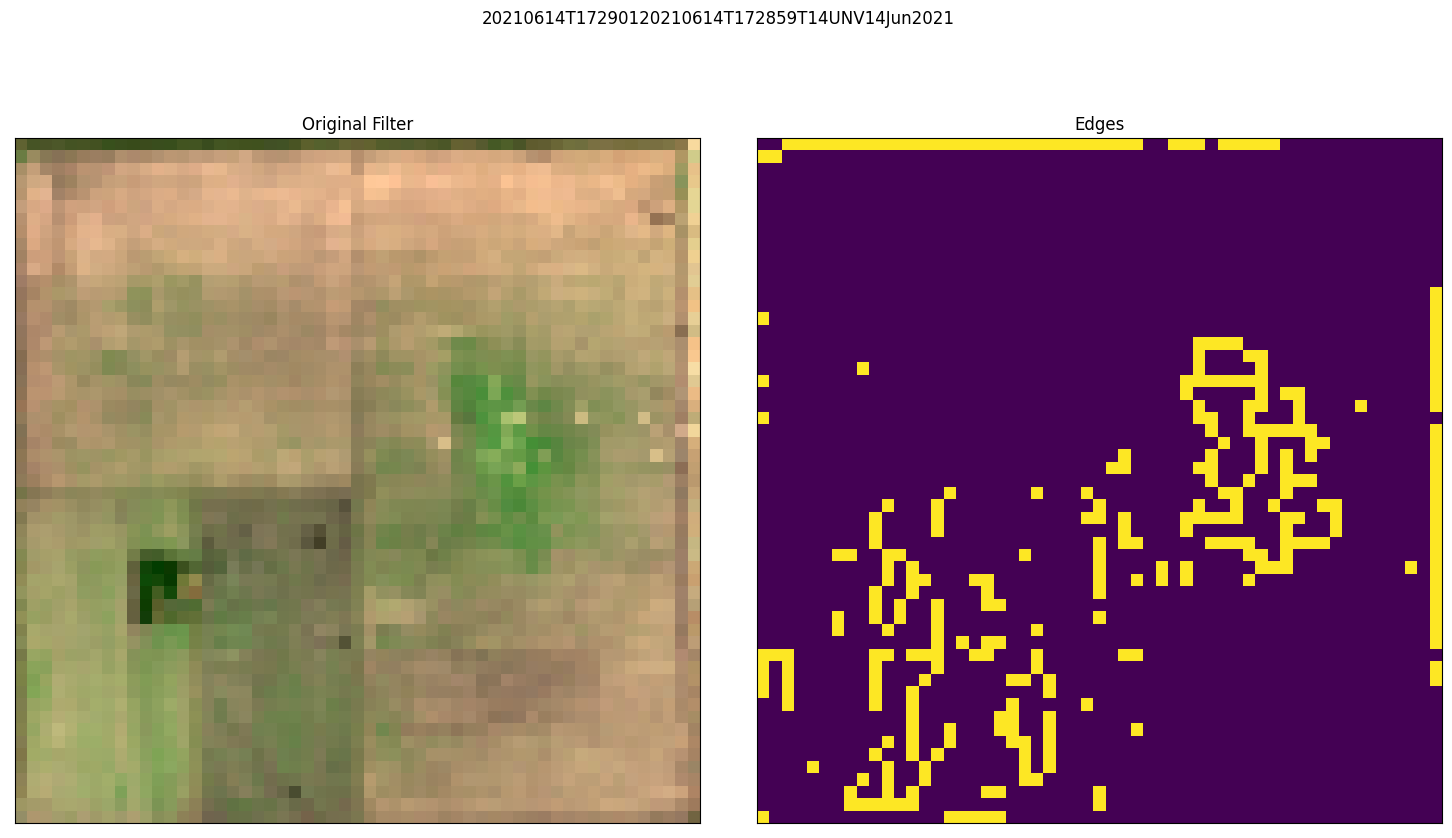

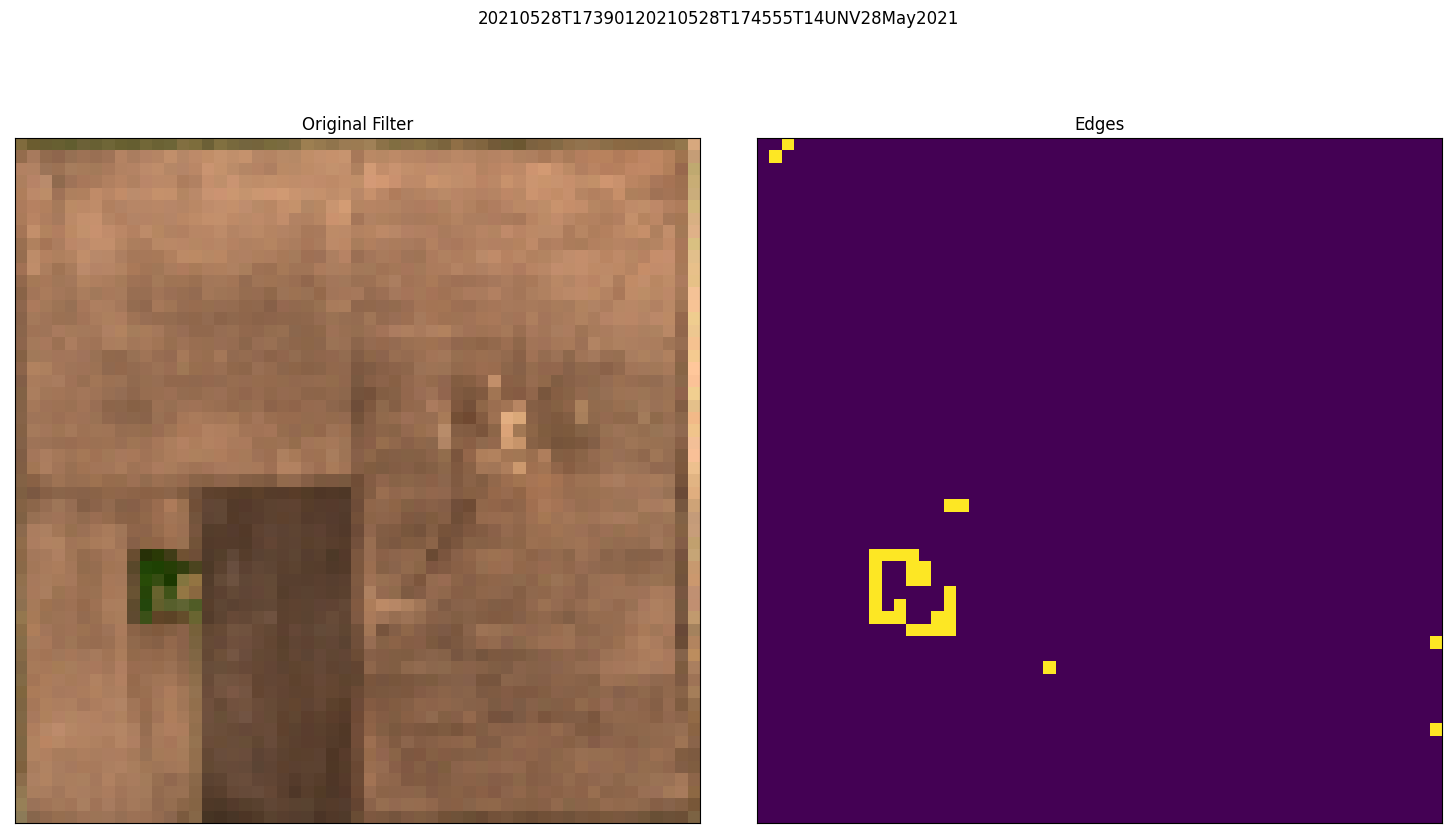

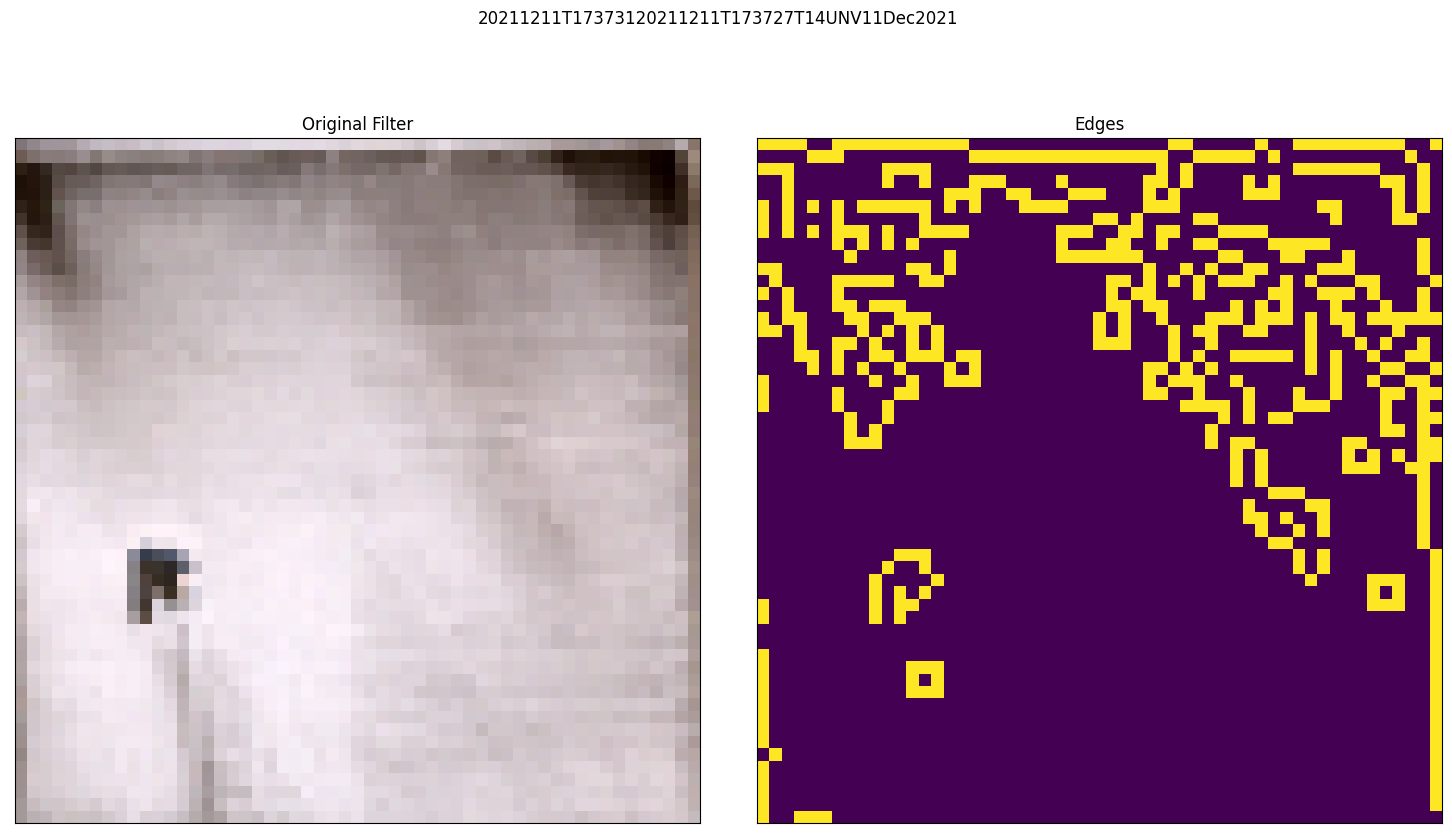

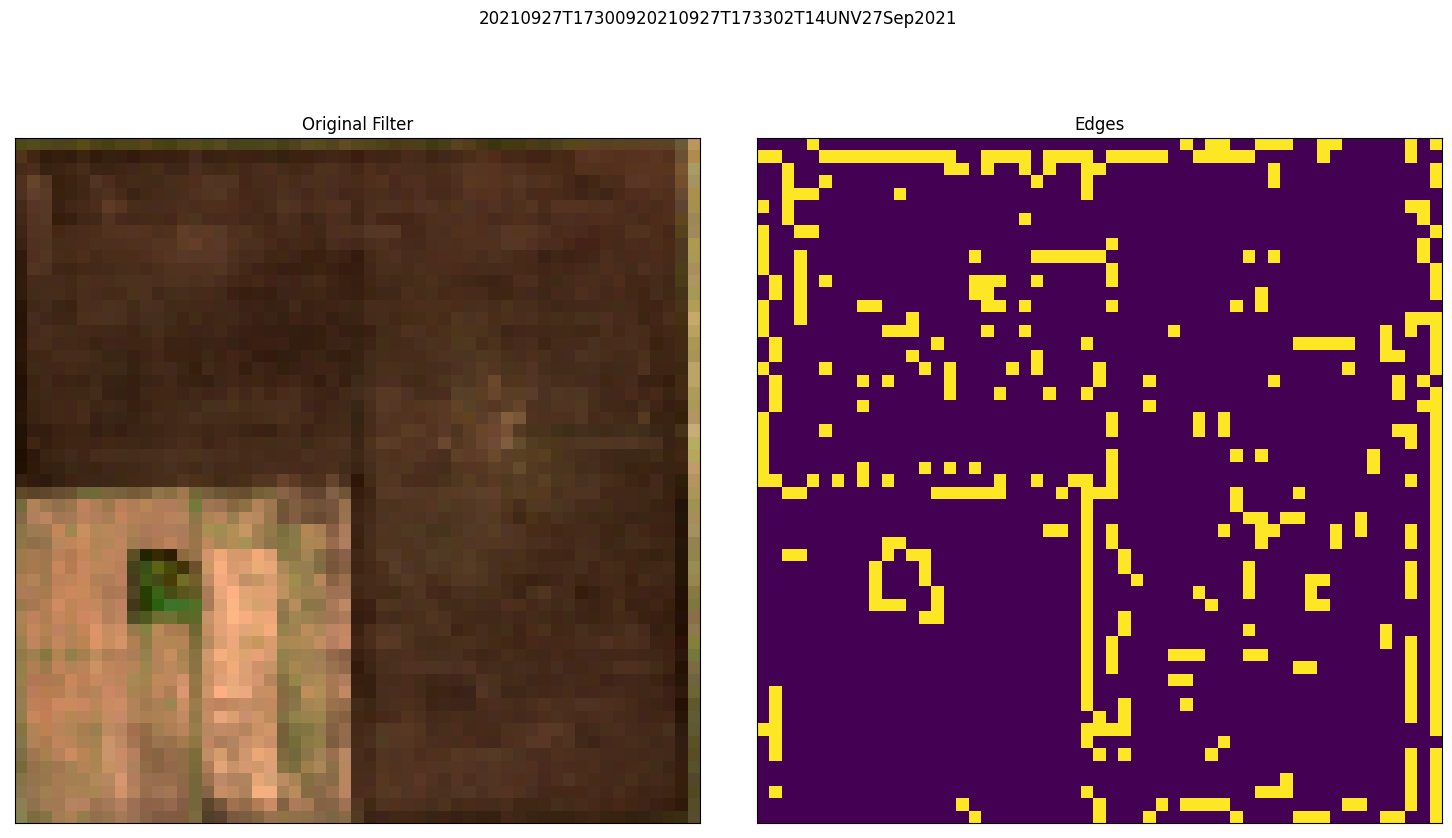

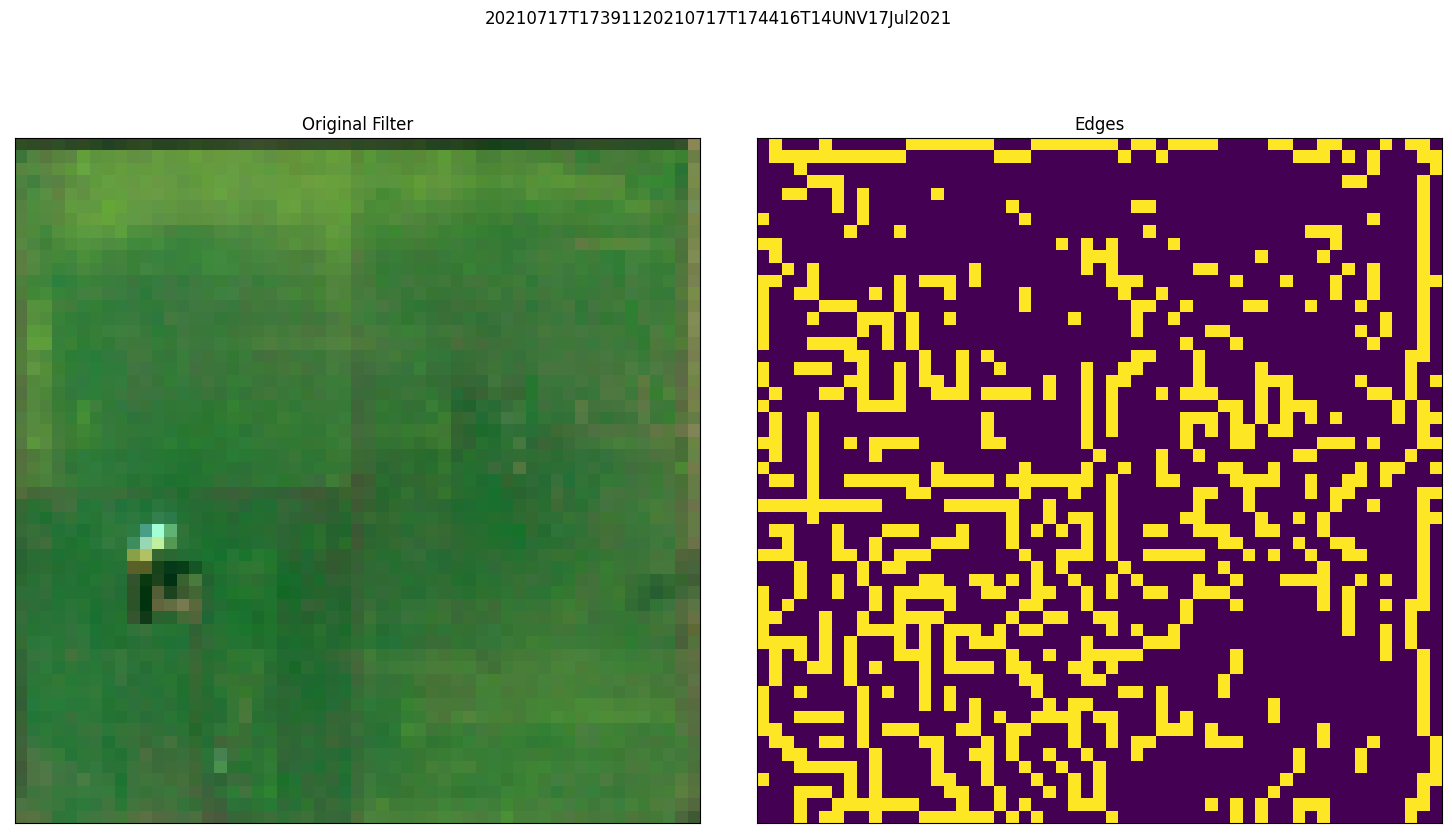

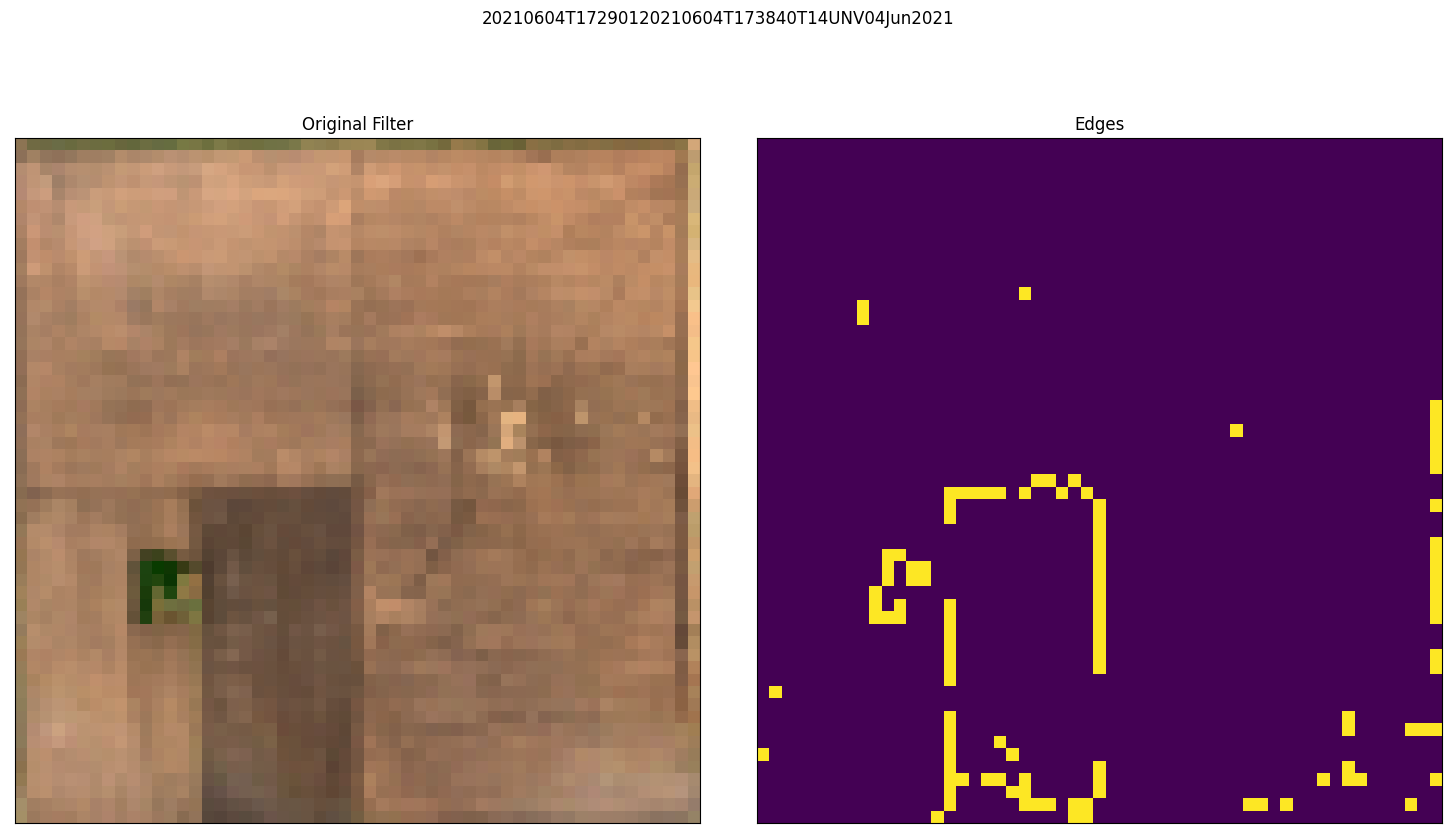

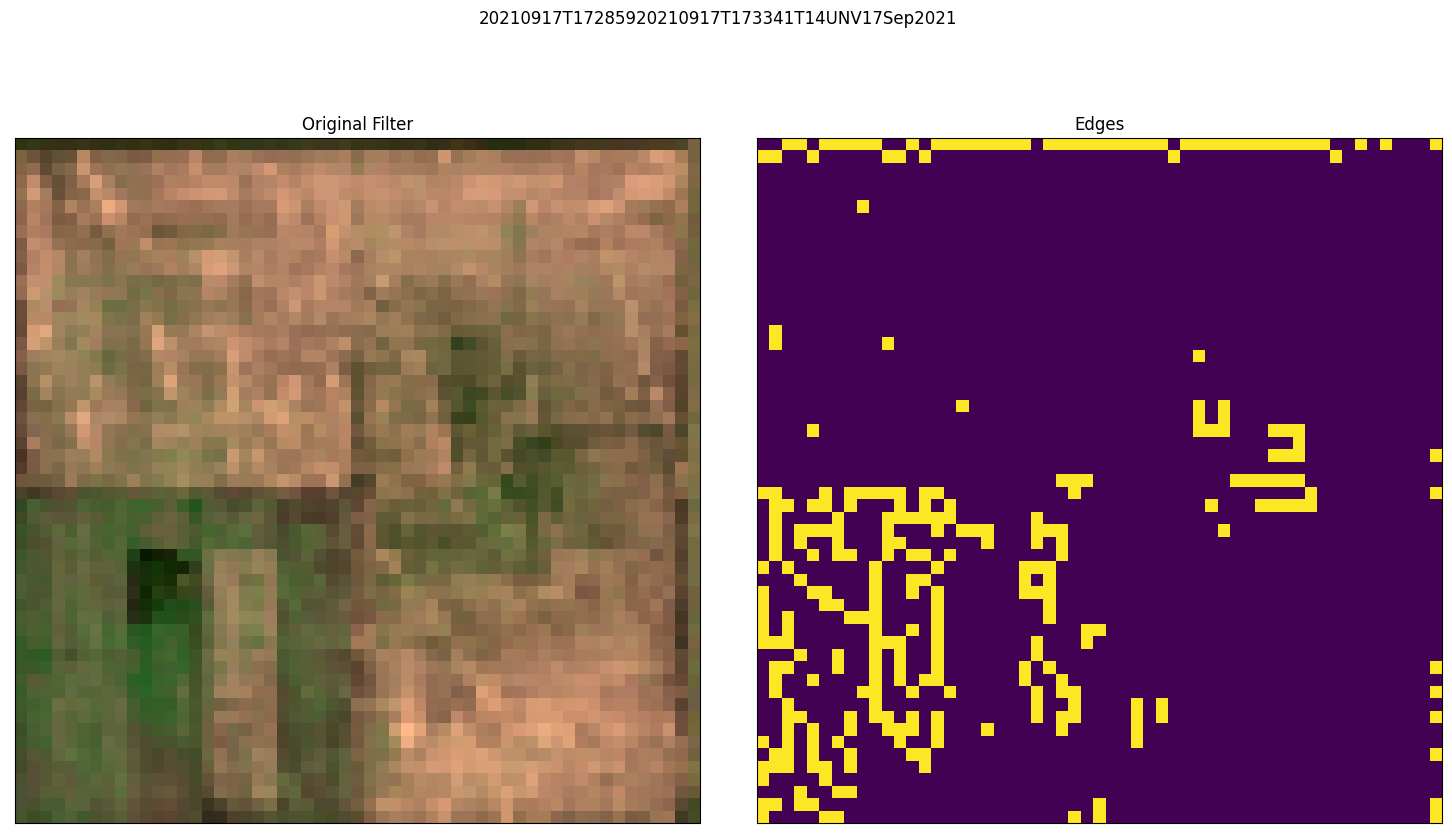

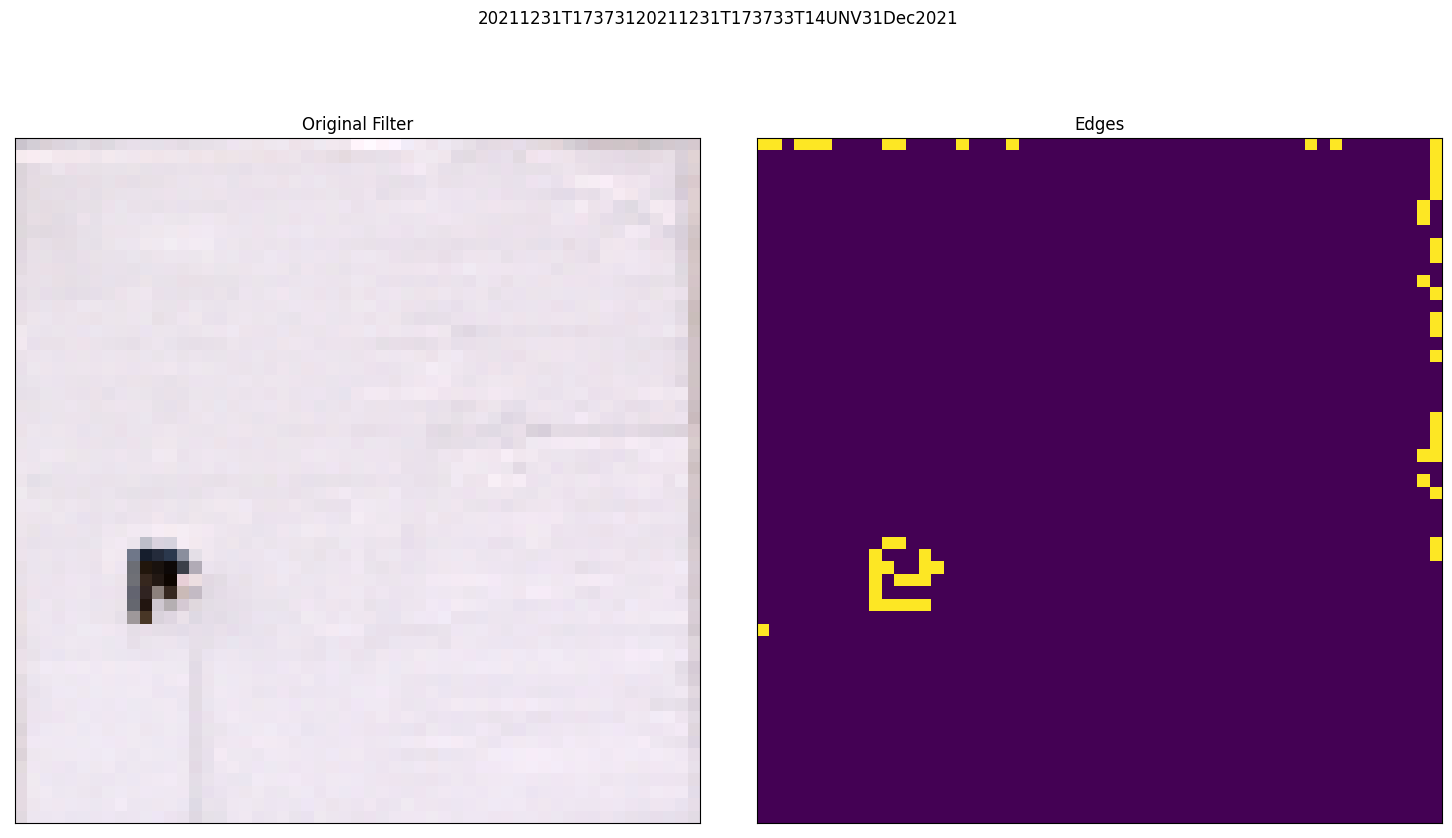

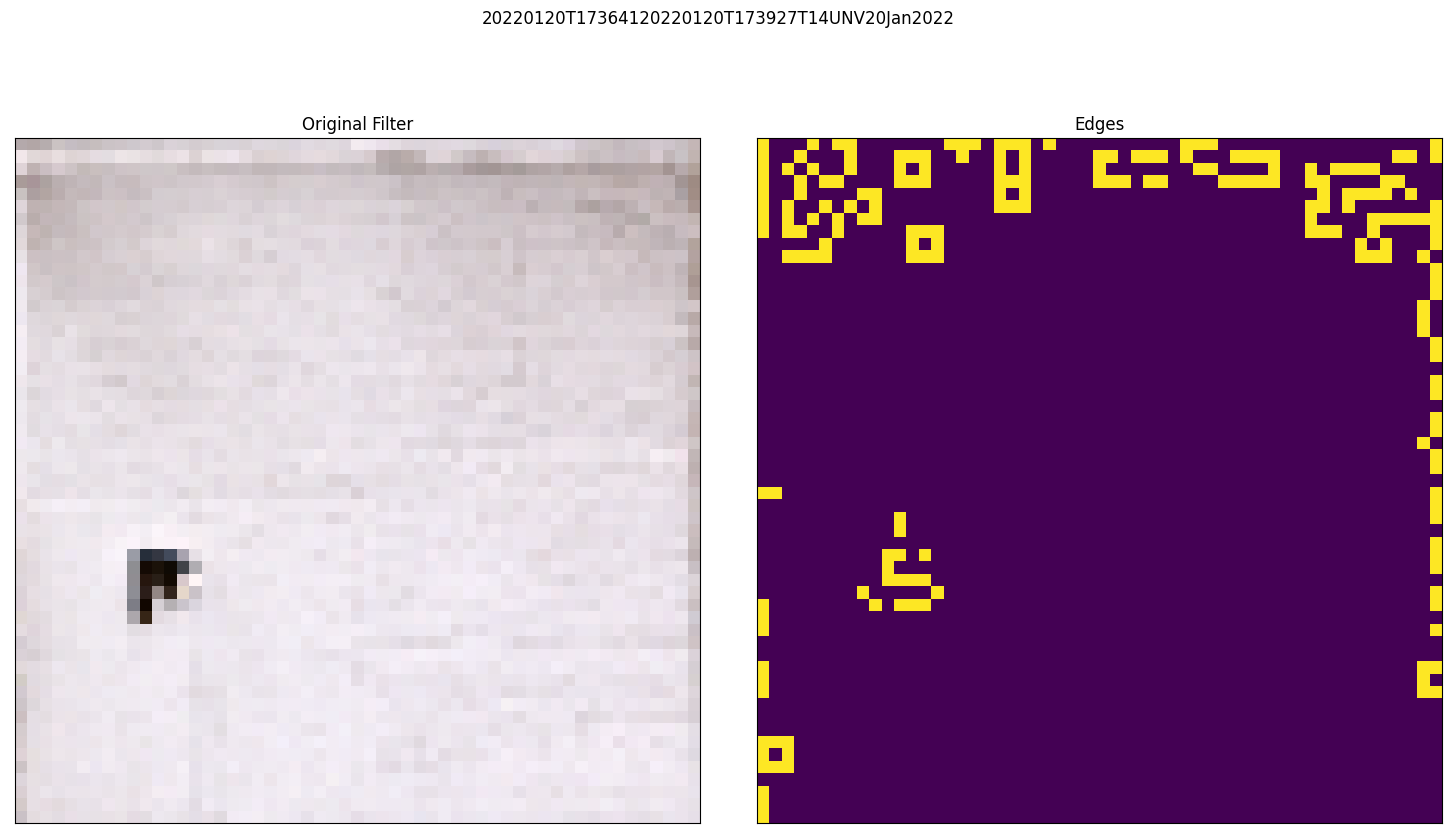

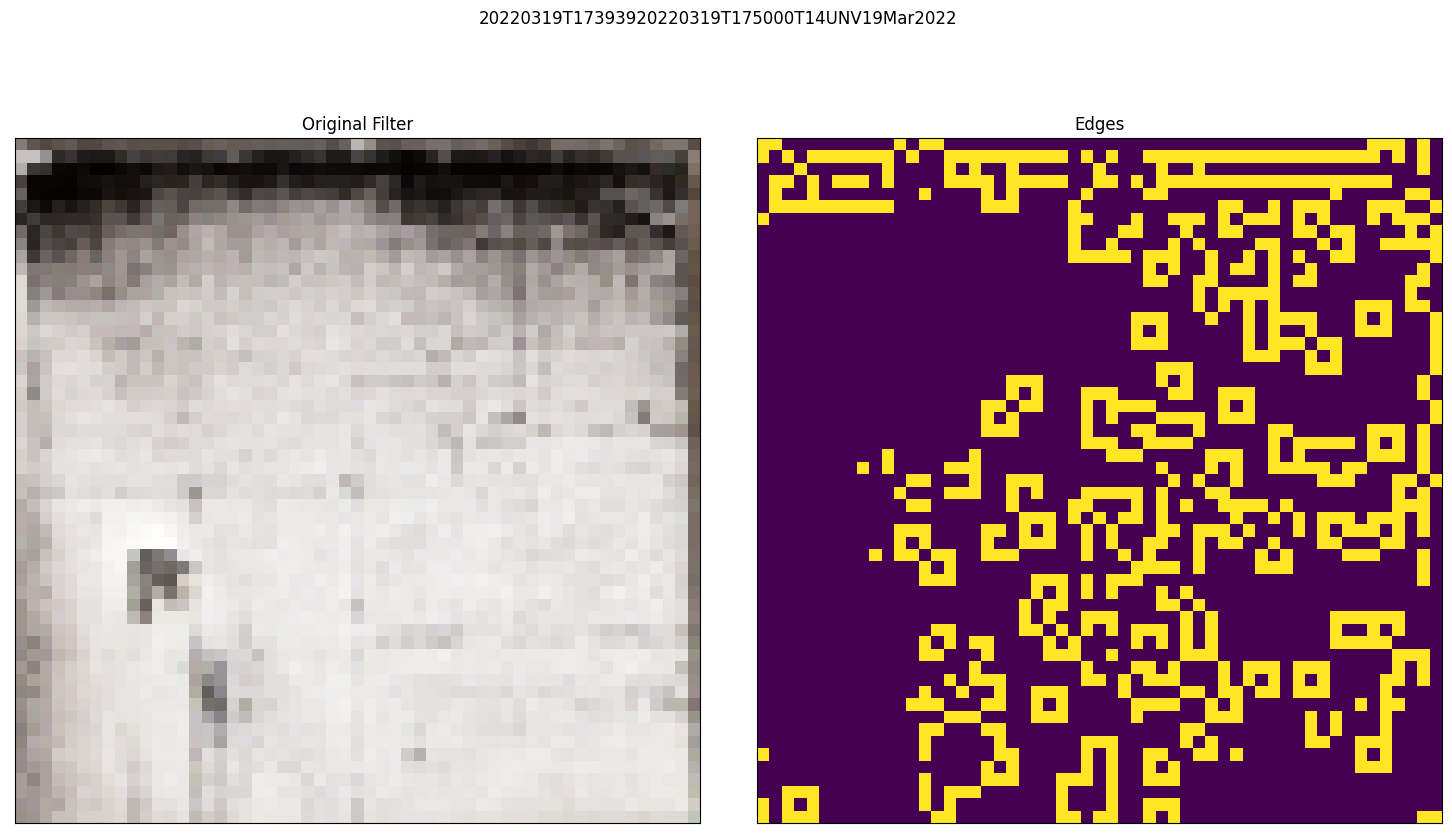

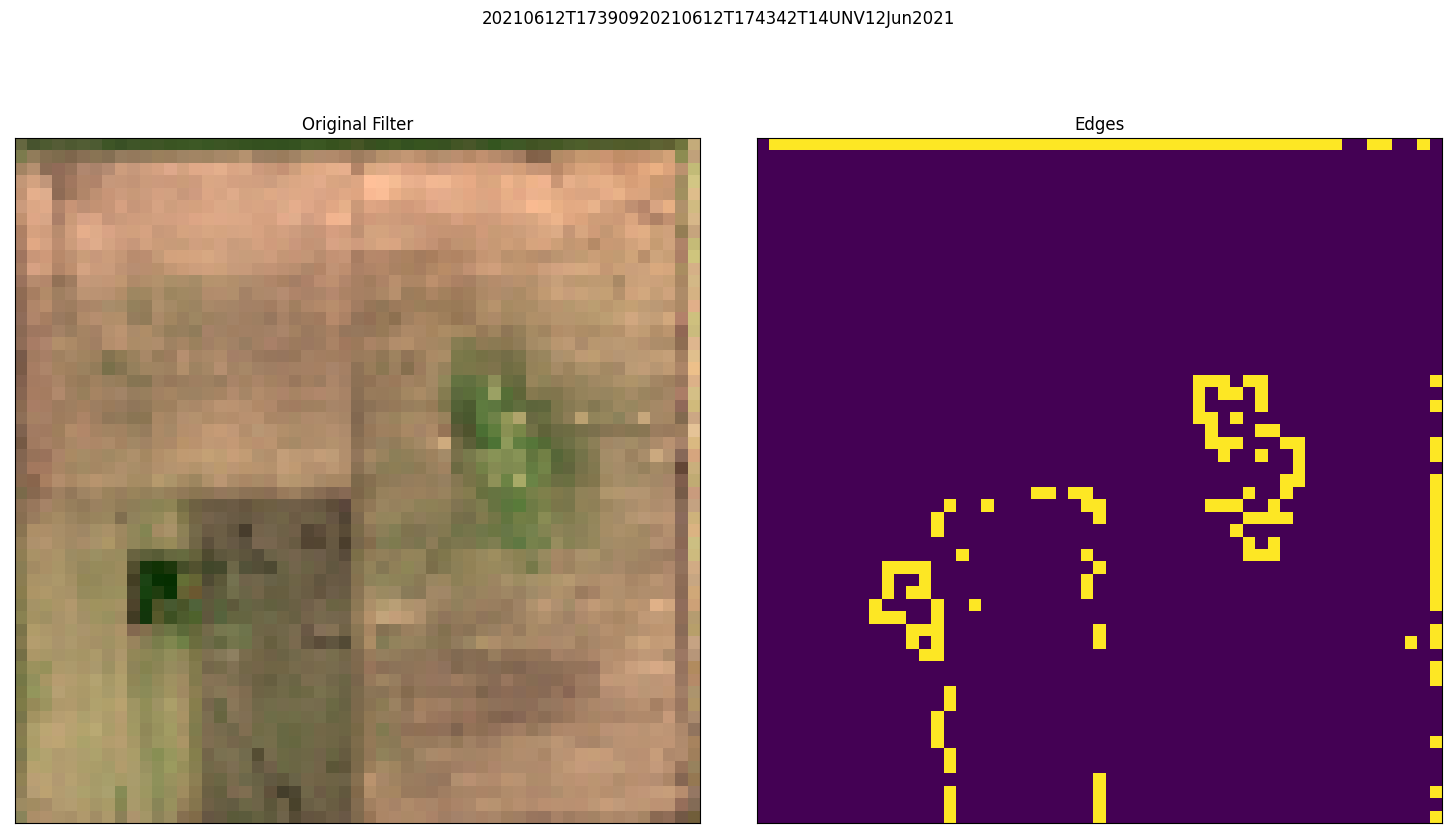

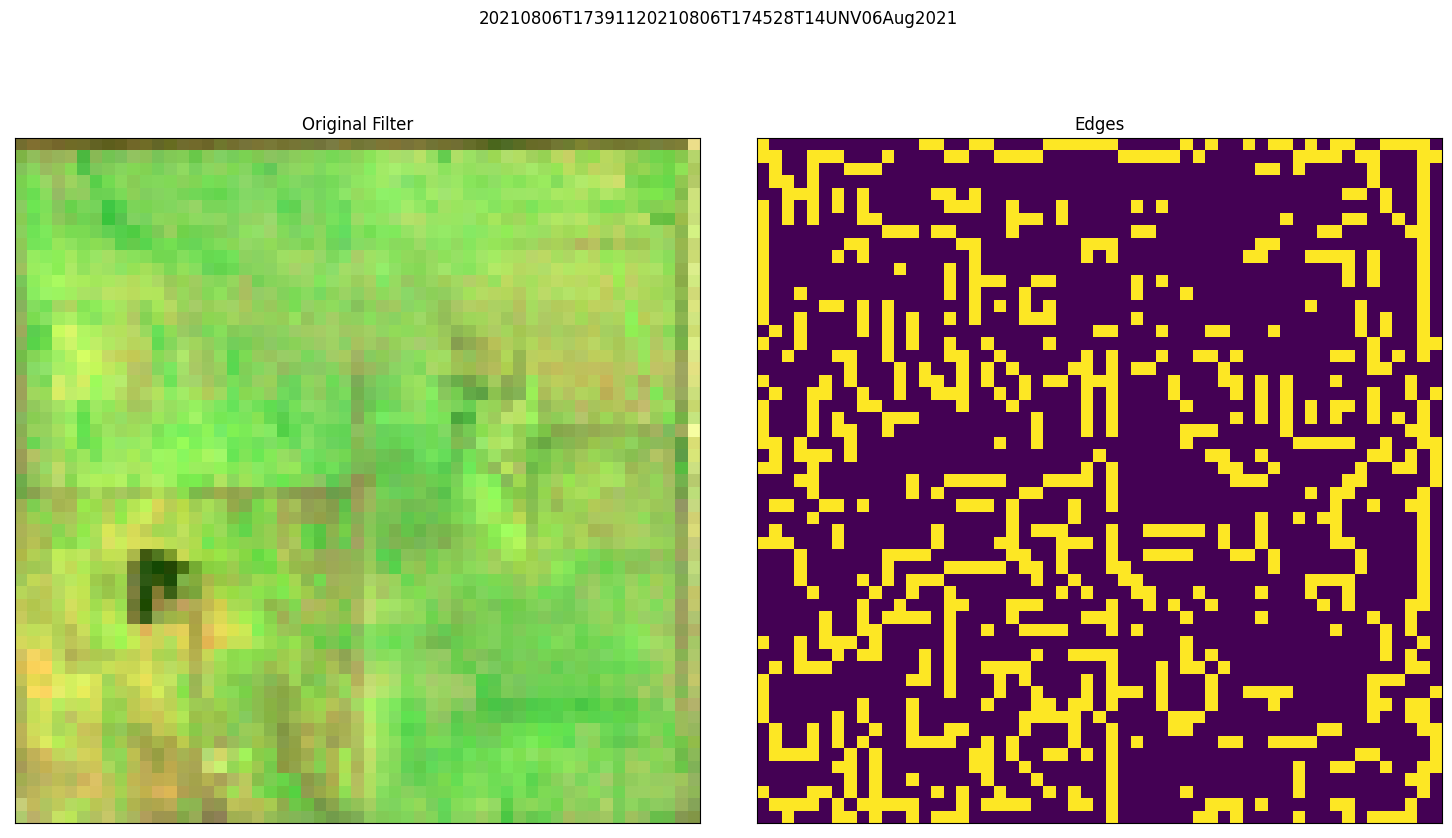

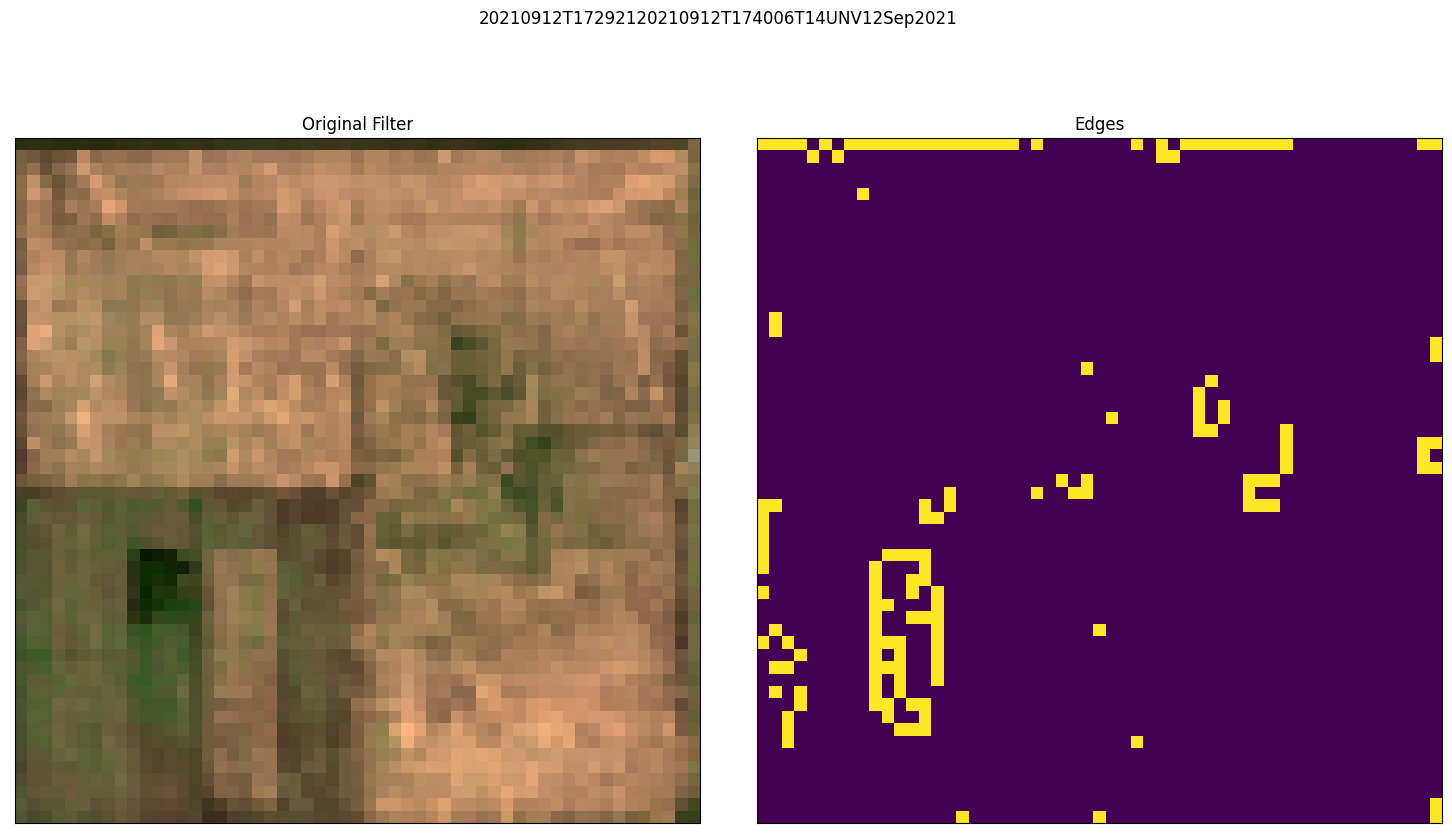

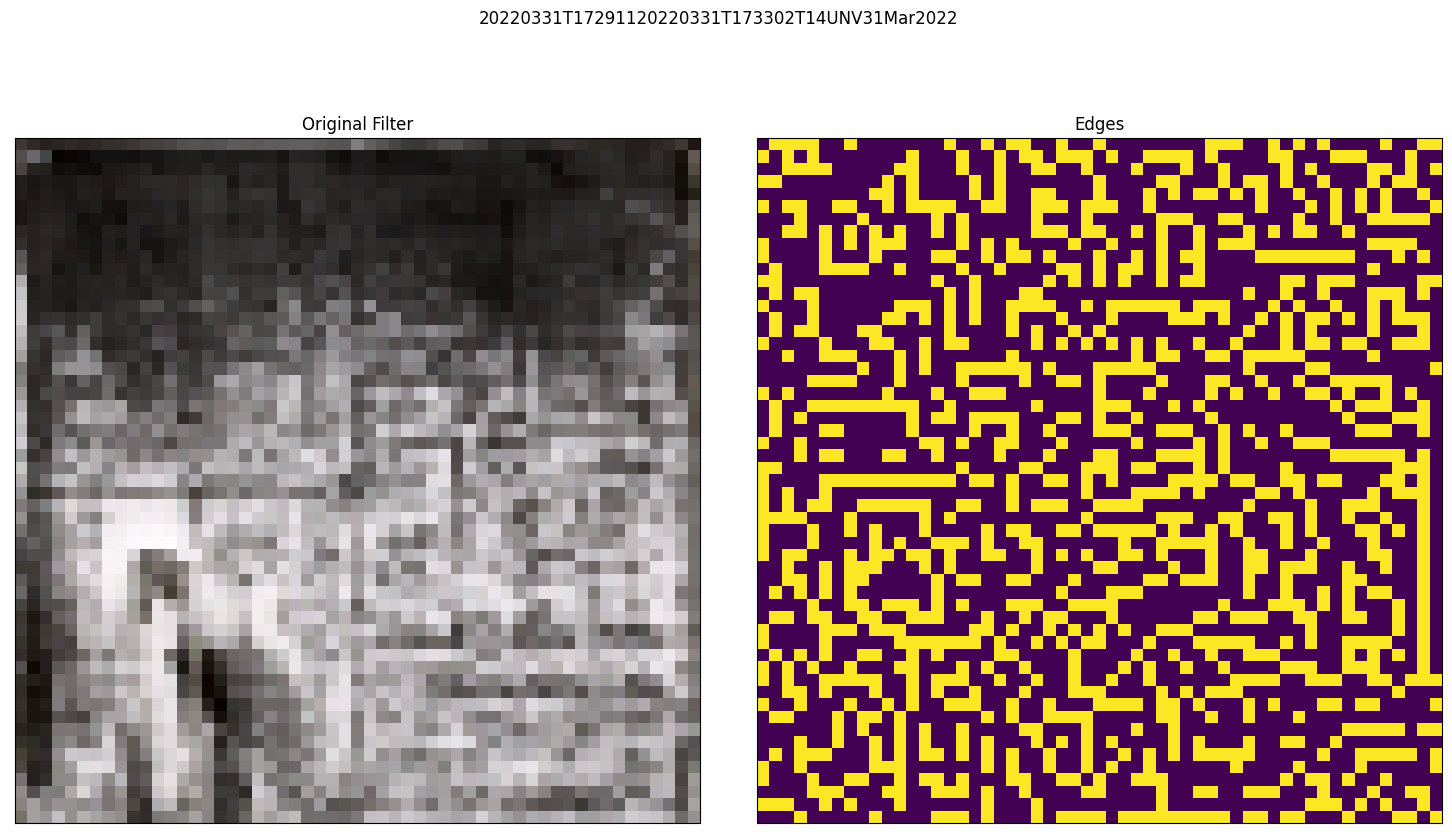

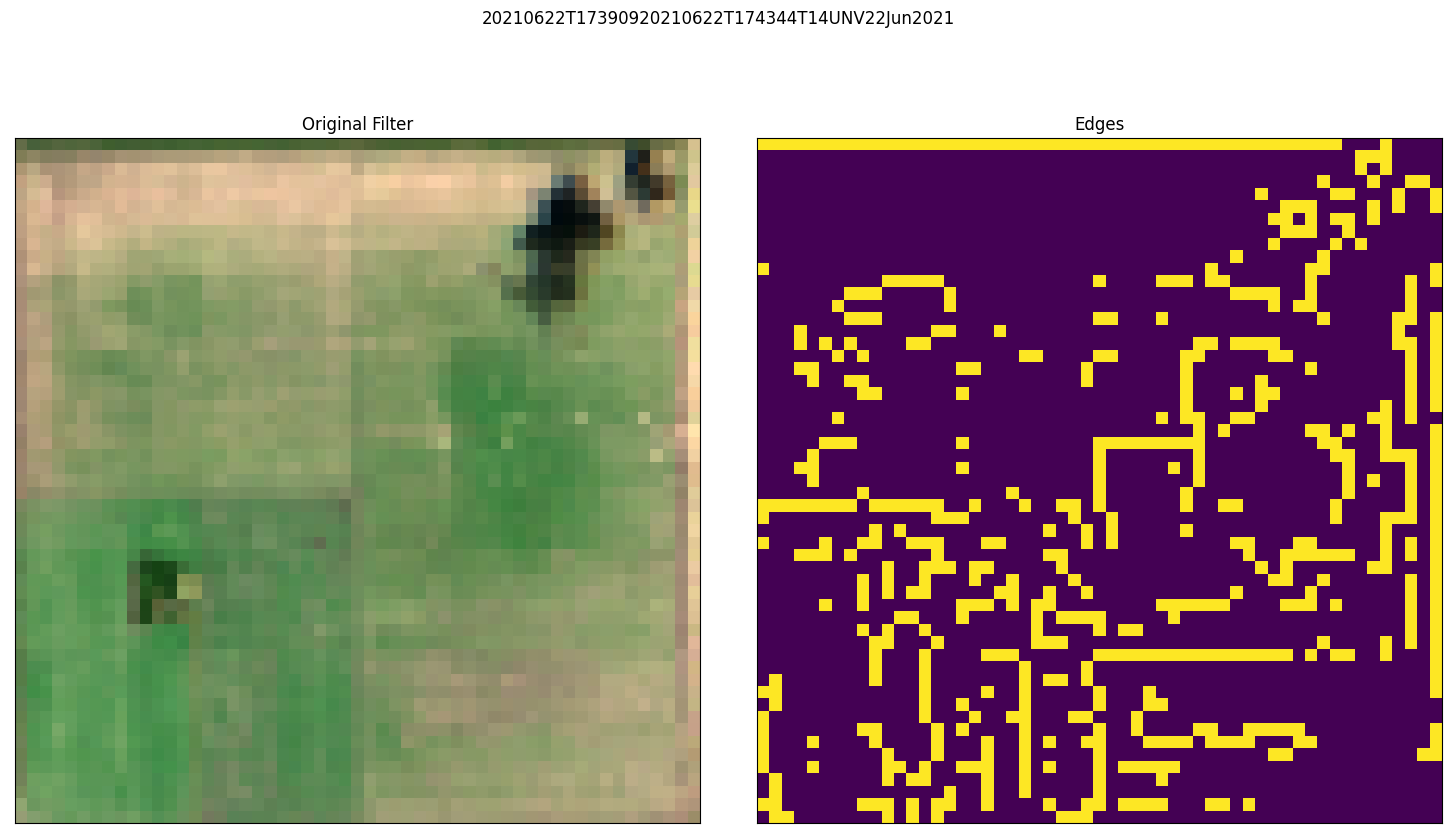

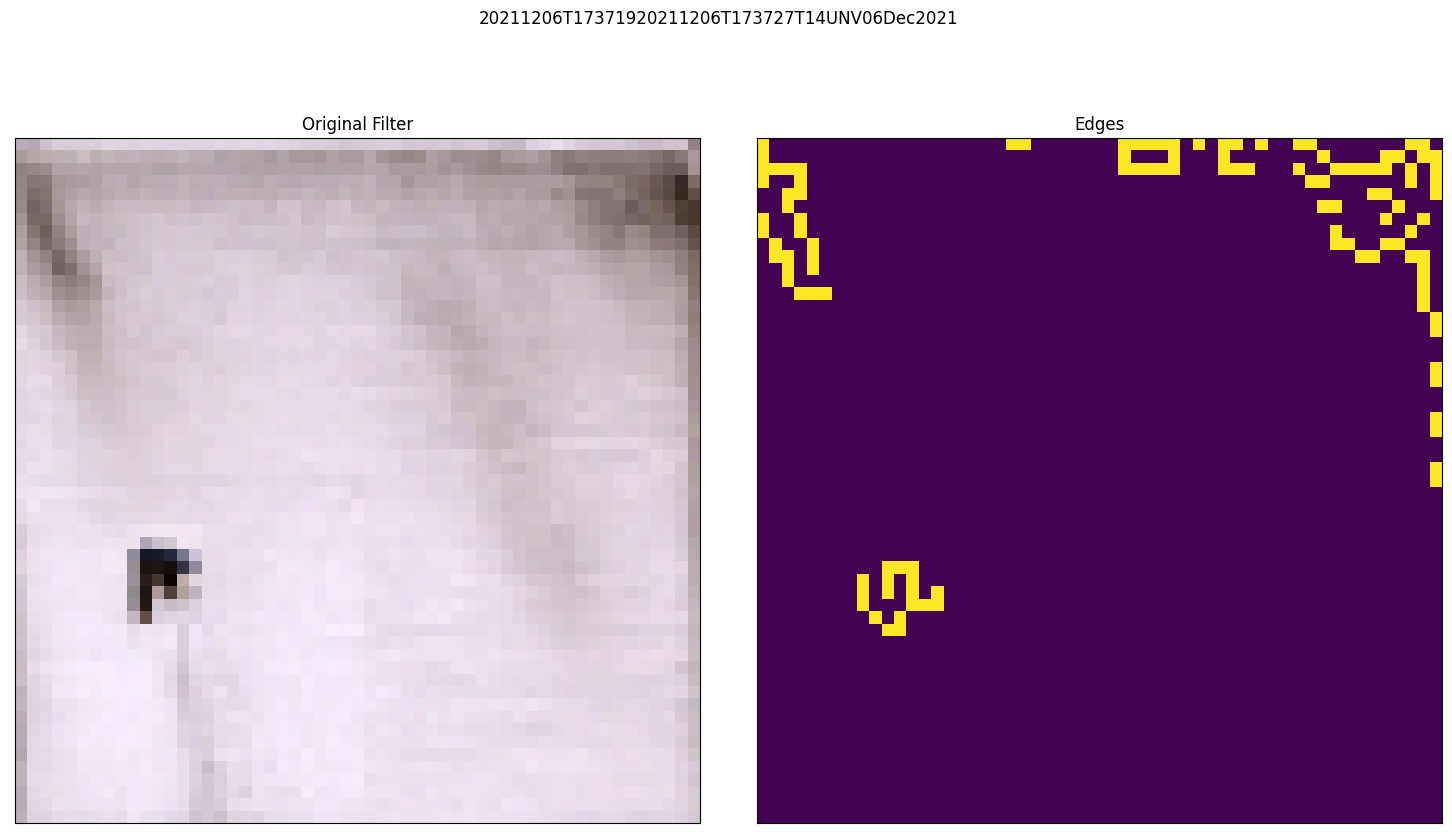

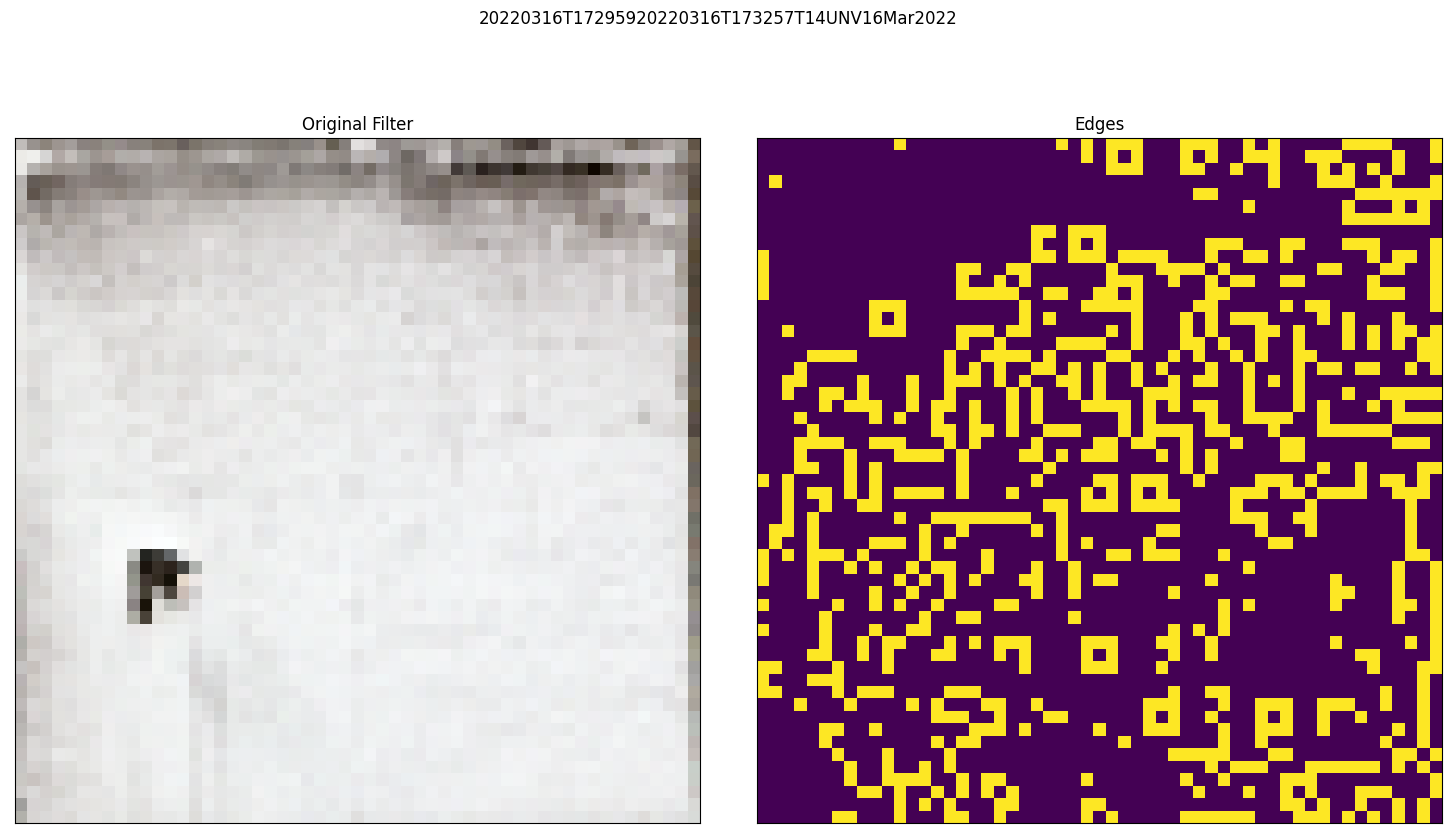

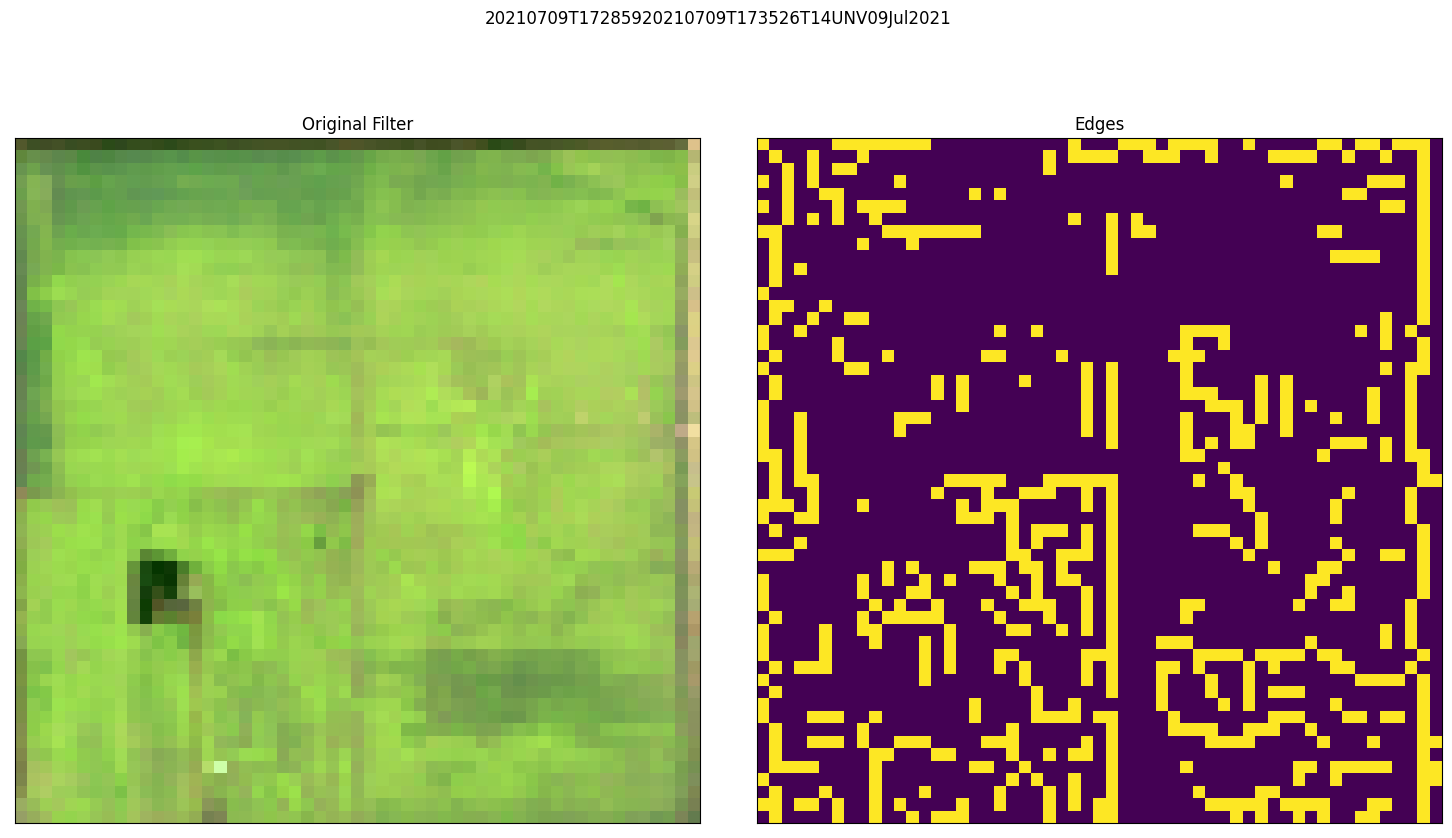

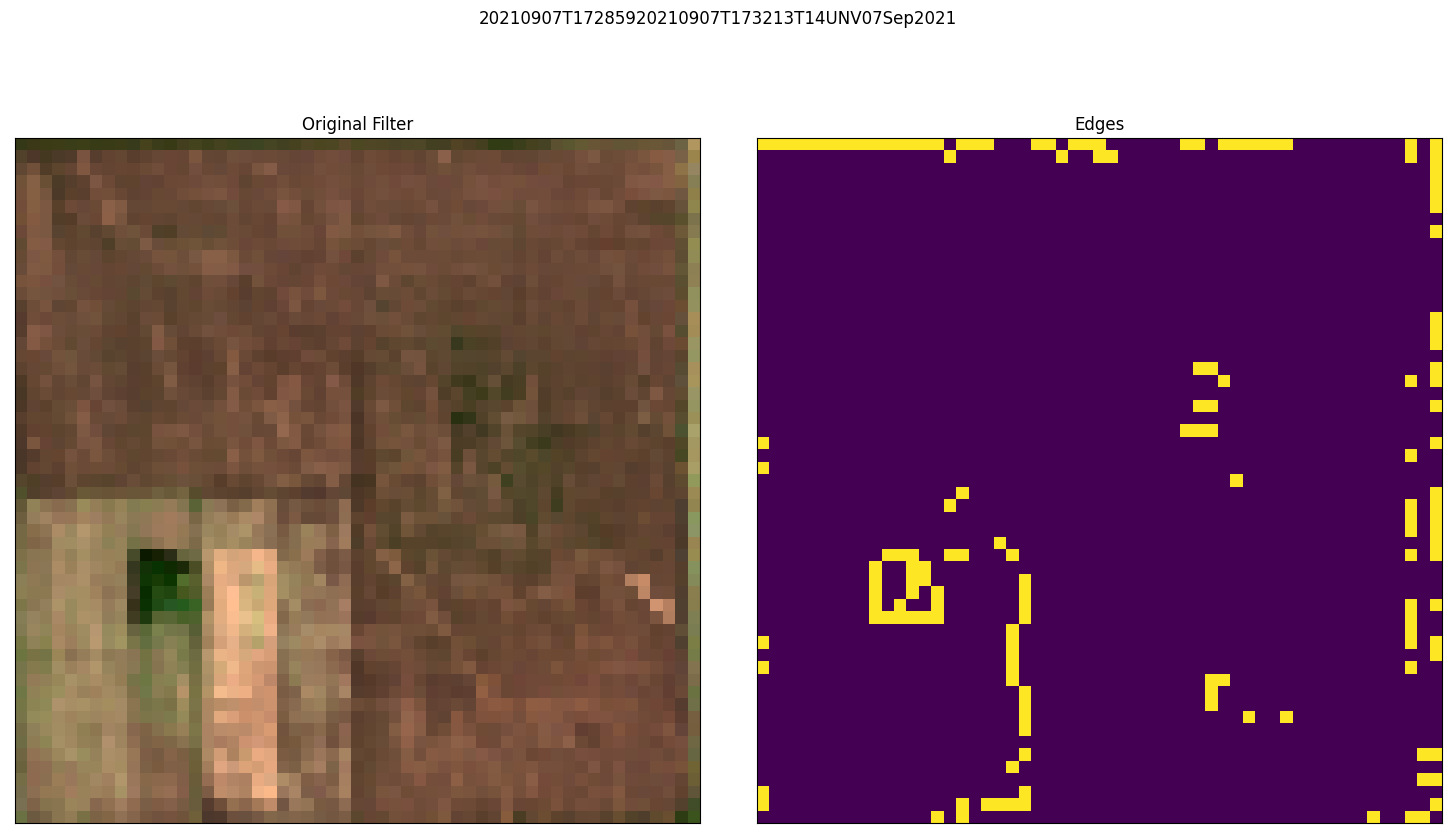

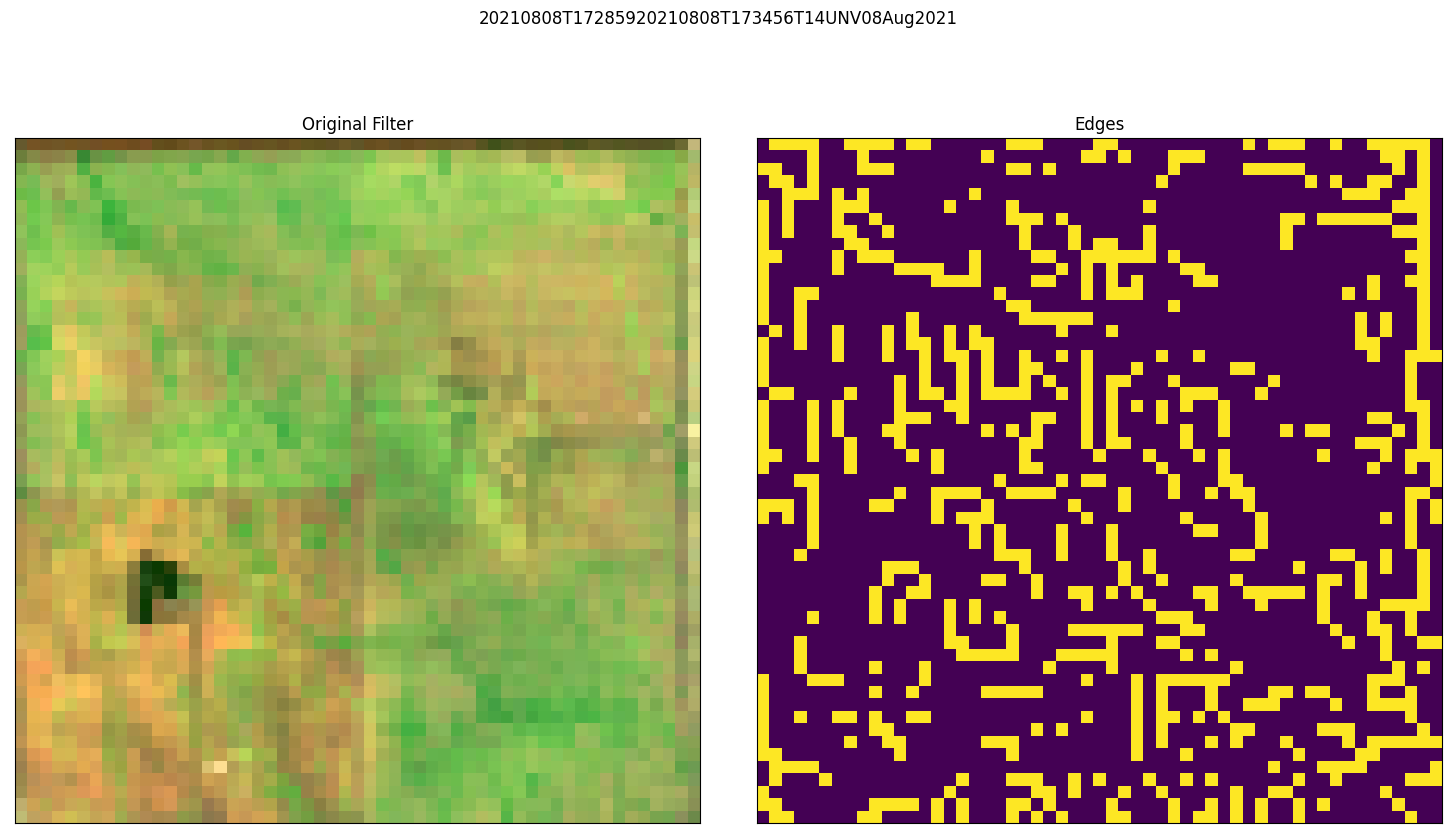

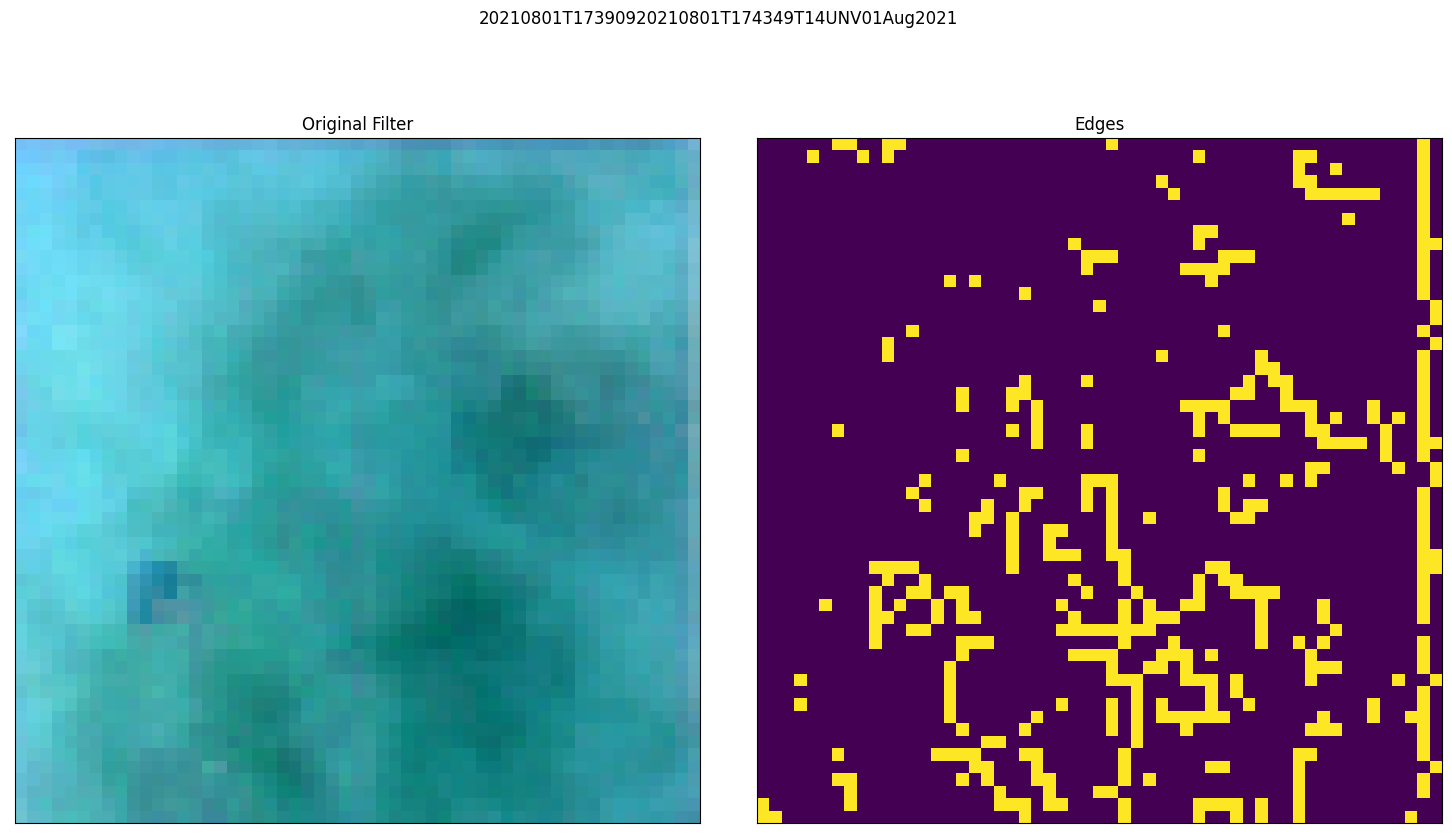

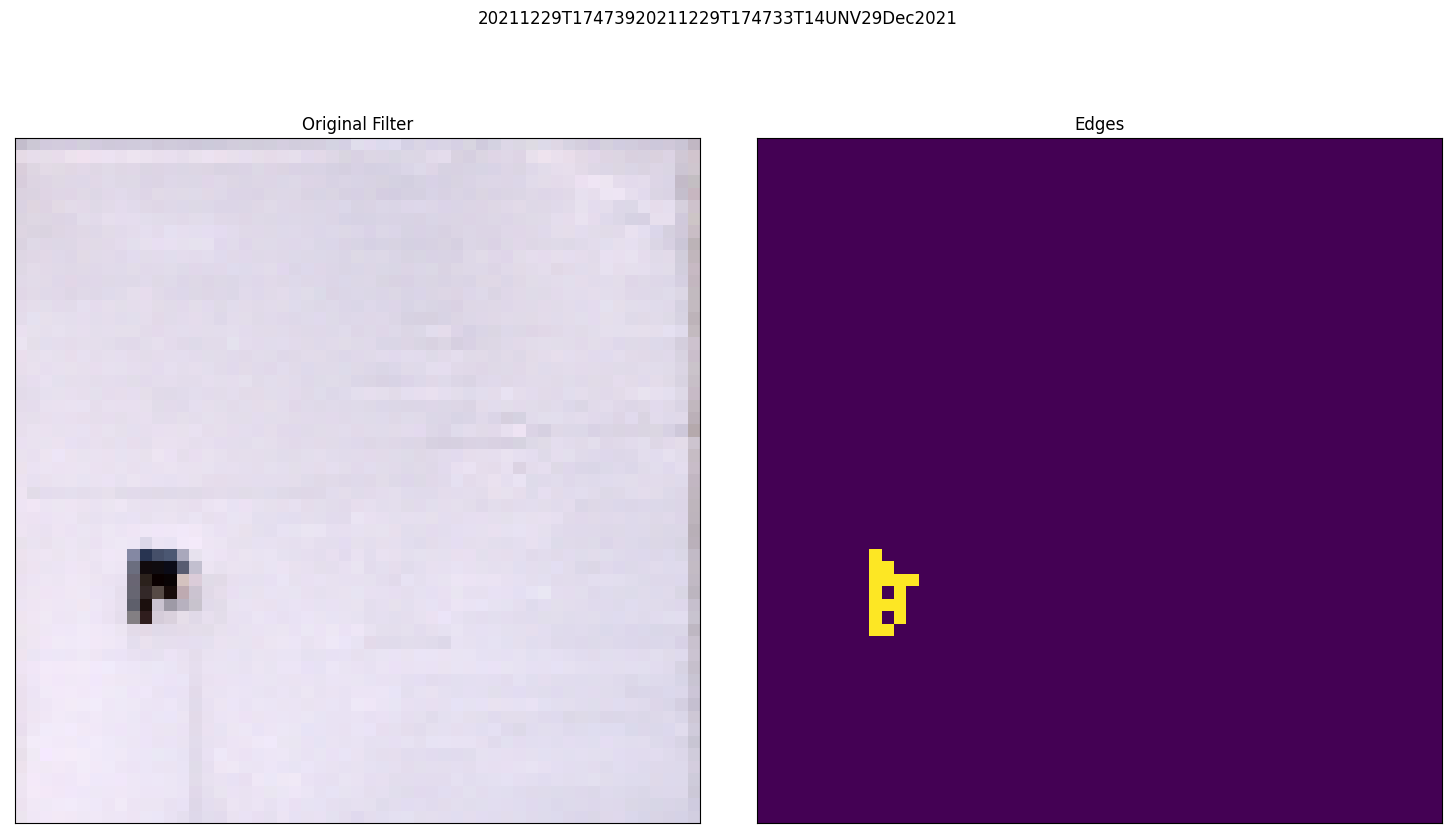

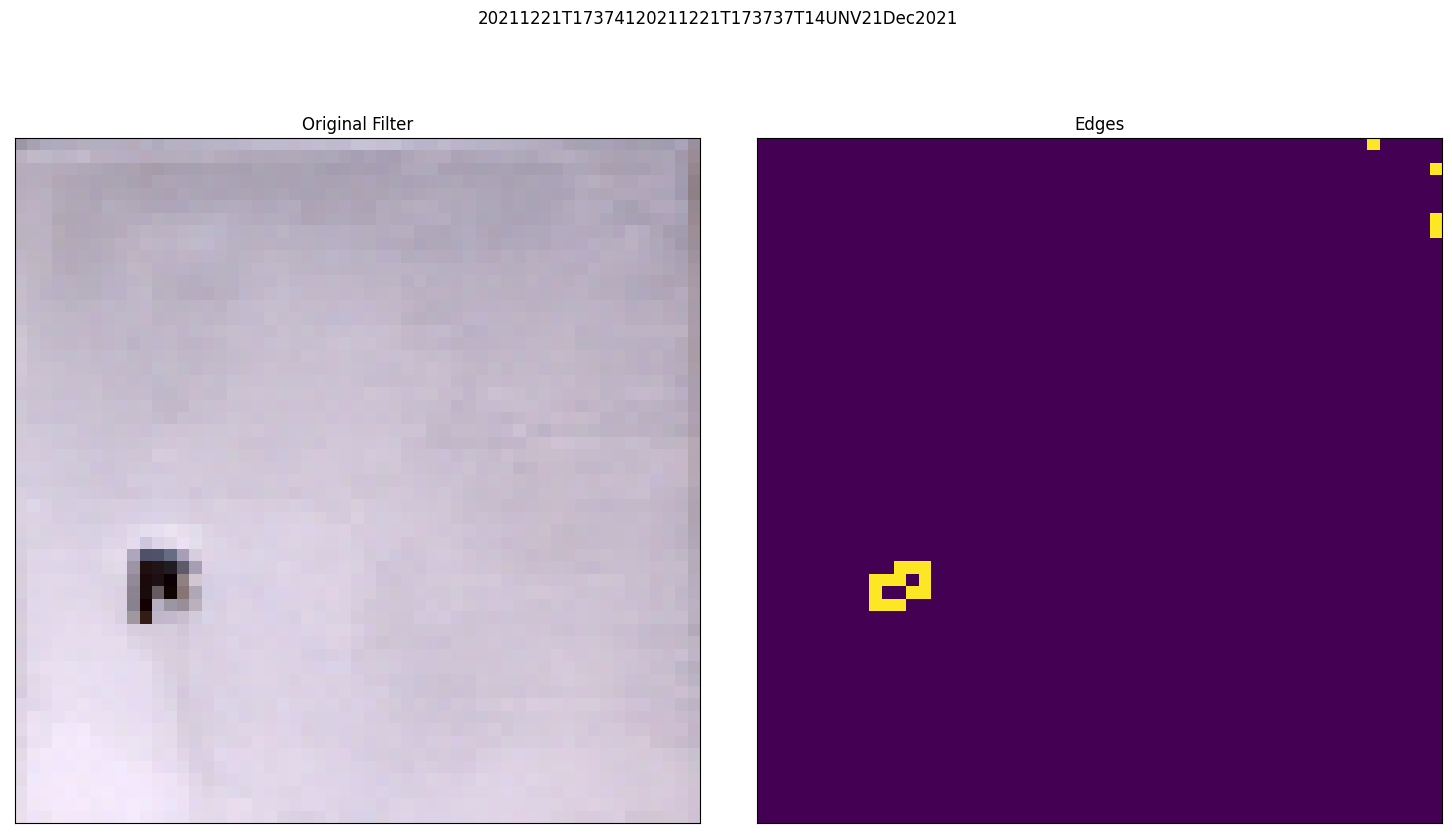

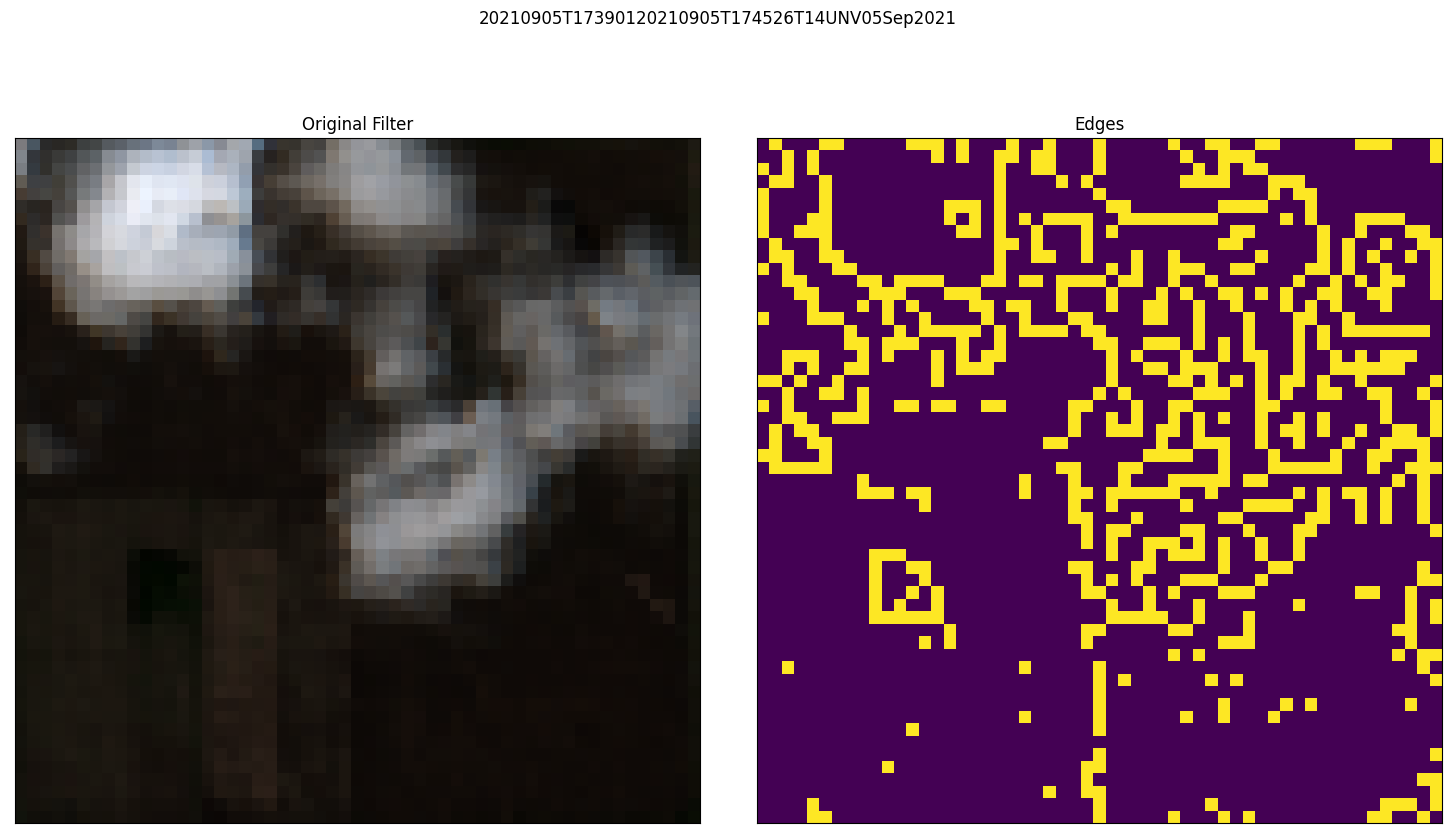

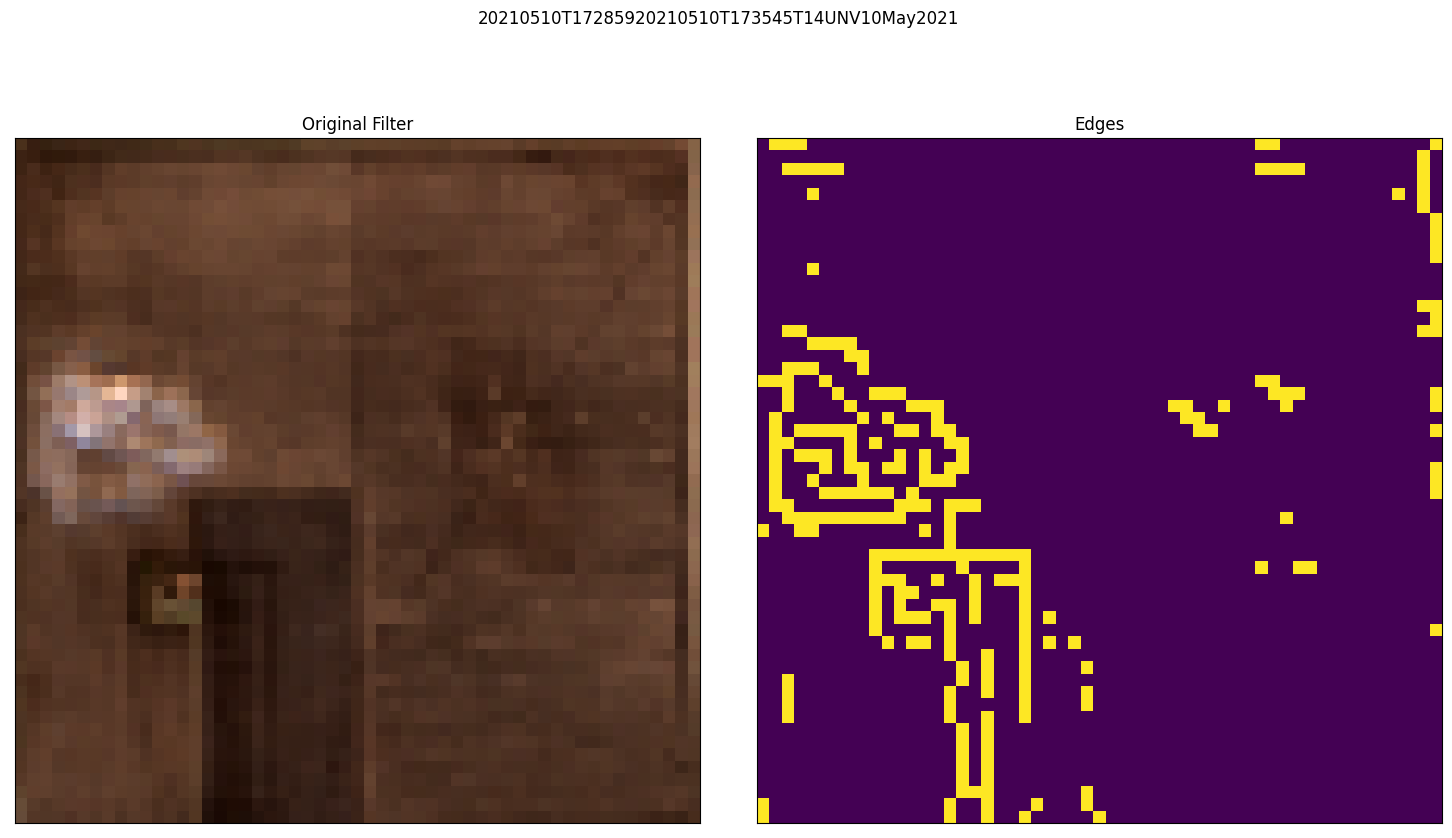

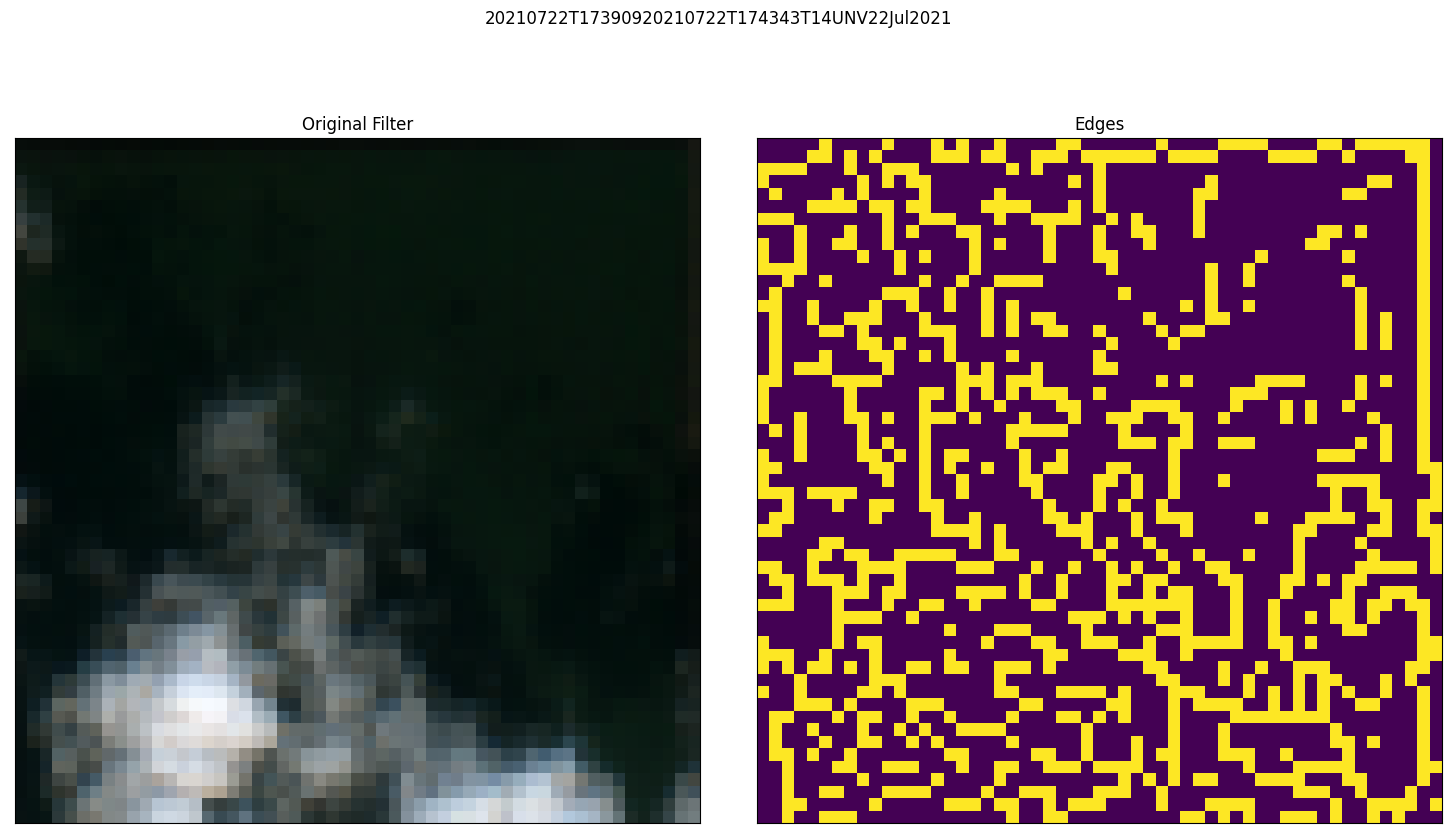

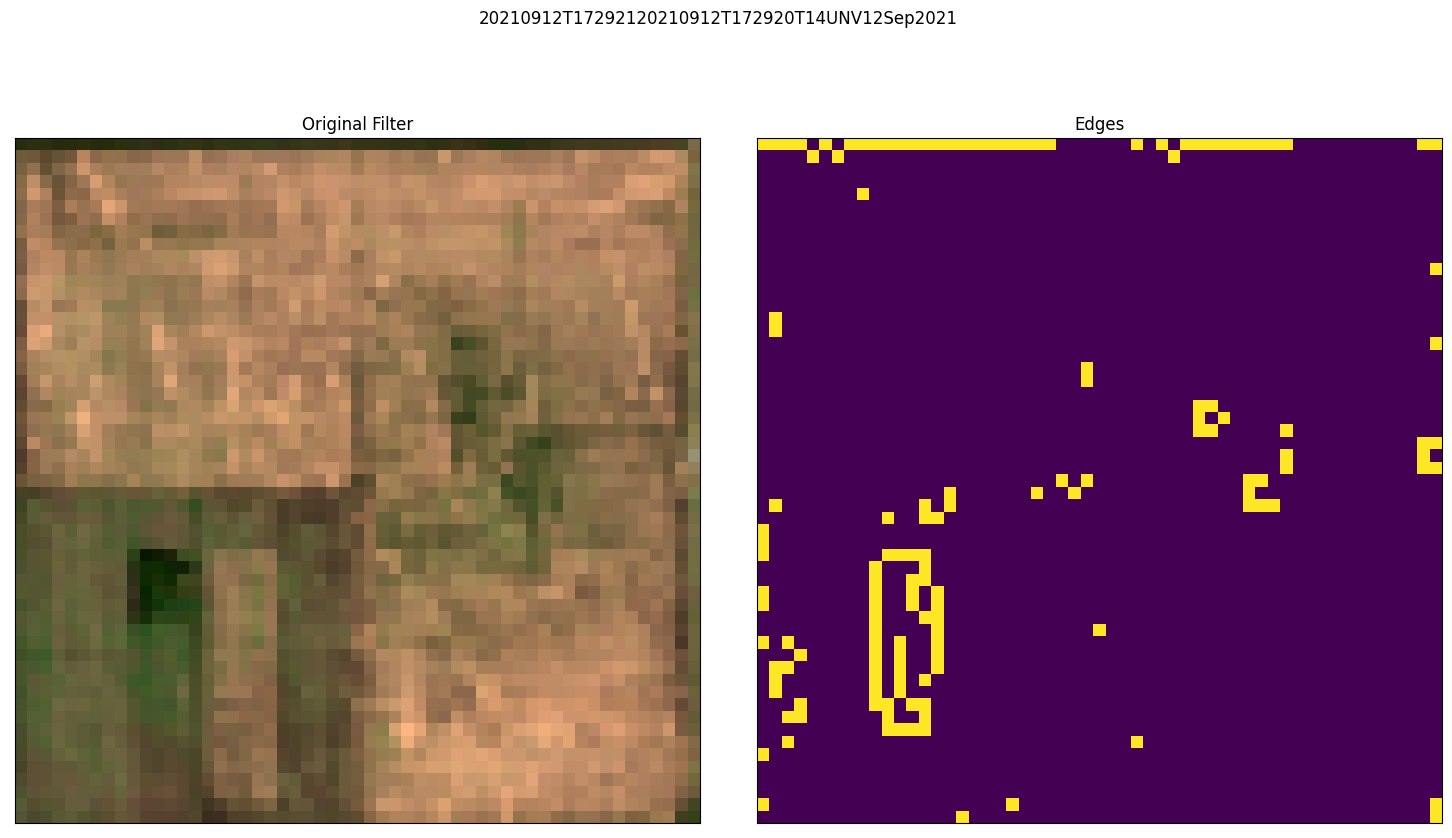

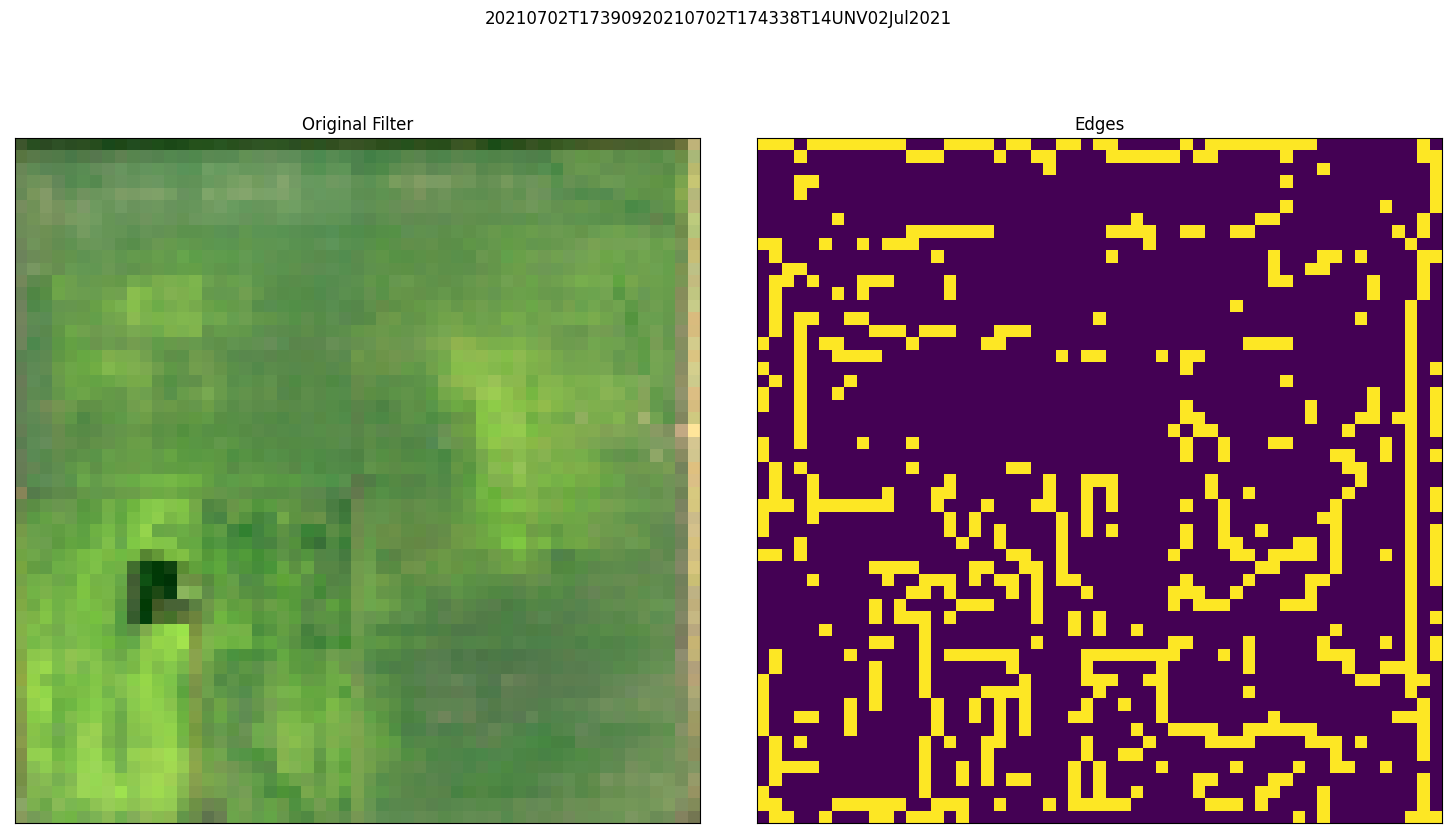

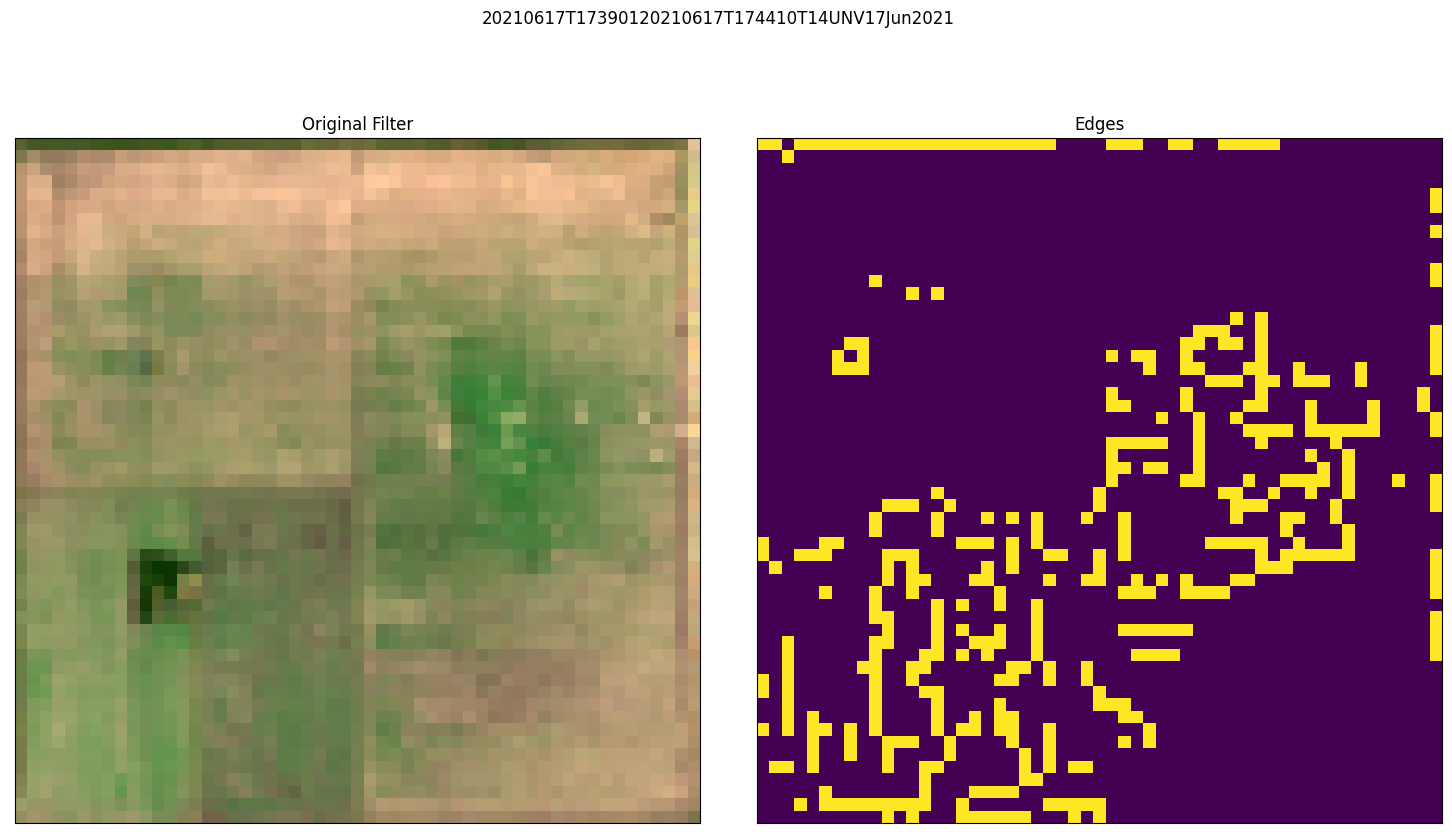

In [21]:
for key in img_keys:
    img = images[key]
    image, hsv_filter, grayscale_filter, gaussian_filter, grayscale_gaussian_filter, grayscale_canny, gaussian_canny, grayscale_gaussian_canny = edge_detection_preprocessing(img, 50, 50)
    visualize_filter_edges(image, grayscale_gaussian_canny, key)

In [8]:
im = convert_to_eight_bits(images[img_keys[0]])
#o = draw_grid(im)
#plt.imshow(o)

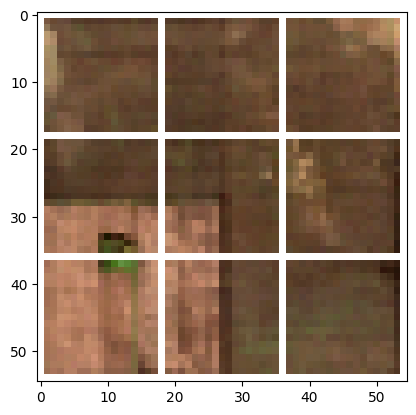

In [12]:
quadrants = split_image(im)

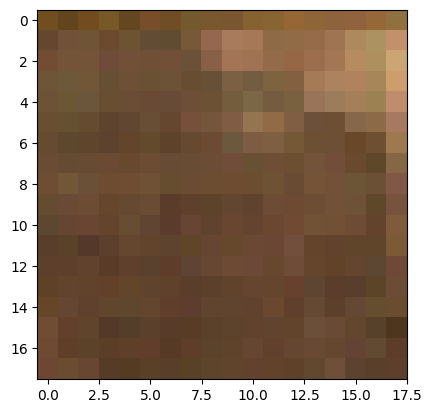

In [15]:
plt.imshow(quadrants[list(quadrants.keys())[2]])

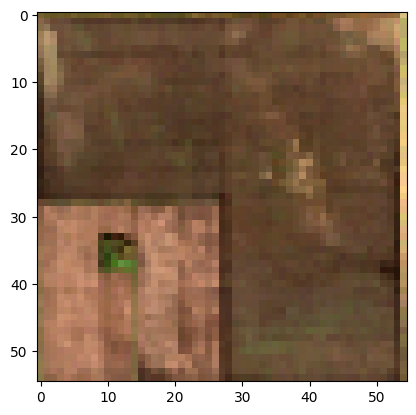

In [16]:
plt.imshow(im)

In [17]:
cv2.imread('/home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba/20200702T17391120200702T174635T14UNV02Jul2020')

[ WARN:0@15.380] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba/20200702T17391120200702T174635T14UNV02Jul2020'): can't open/read file: check file path/integrity


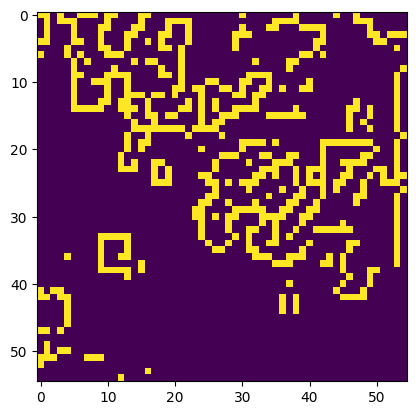

In [20]:
plt.imshow(cv2.Canny(convert_to_eight_bits(images[img_keys[4]]), 100, 100, L2gradient=True))